# atmodeller: Fugacity Coefficients for Non-Ideality


In [1]:
import numpy as np
import pandas as pd
from atmodeller import __version__, debug_logger, debug_file_logger
from typing import Type
from pytest import approx


from atmodeller.eos.holland import get_holland_fugacity_models, CORKSimpleCO2HP91, CORKCO2HP98
from atmodeller.eos.saxena import H2LowPressureSS92, H2HighPressureSS92, H2HighPressureSF88, H2HighPressureSS92_Refit, H2HighPressureSF88_Refit, get_saxena_fugacity_models

debug_logger()

In [2]:
#Plotting Tools:
import matplotlib
import matplotlib.pyplot as plt
plt.rc("savefig", dpi=300)
plt.rc('figure', dpi=300)
plt.rc('text', usetex=True)
plt.rc('font', size=15)
plt.rc('xtick', direction='in') 
plt.rc('ytick', direction='in')
plt.rc('xtick.major', pad=5) 
plt.rc('xtick.minor', pad=5)
plt.rc('ytick.major', pad=5) 
plt.rc('ytick.minor', pad=5)
plt.rc('lines', dotted_pattern = [0.5, 1.1])

font={'weight':'bold',
     'size': 15}
matplotlib.rc('font', **font)
plt.rcParams["figure.figsize"] = (7,5)

### Shi & Saxena and Saxena & Fei Models

In [3]:
SS_model_lo = H2LowPressureSS92()
SS_model_hi = H2HighPressureSS92_Refit()


SS_model_lo.volume(temperature=673, pressure=5)


print(SS_model_hi.volume(temperature=1473, pressure=3000)*10)
print(SS_model_hi.volume(temperature=1473, pressure=10000)*10)
print(SS_model_hi.volume(temperature=1473, pressure=2000)*10)


53.65662037552074
24.954835037882802
74.01244017424102


In [4]:
SF_model_hi = H2HighPressureSF88()
SF_model_hi_refit = H2HighPressureSF88_Refit()
print(SF_model_hi.volume(temperature=2000, pressure=4000)*10)
print(SF_model_hi_refit.volume(temperature=2000, pressure=4000)*10)

874.9211562666428
52.6303666312771


In [5]:
SS_models = get_saxena_fugacity_models()

print(SS_models.keys())

SS_model_CO = SS_models['CO']
SS_model_CO2 = SS_models['CO2']
SS_model_CH4 = SS_models['CH4']
SS_model_H2 = SS_models['H2']
SS_model_O2 = SS_models['O2']
SS_model_S2 = SS_models['S2']
SS_model_SO2 = SS_models['SO2']
SS_model_H2S = SS_models['H2S']

dict_keys(['CH4', 'CO', 'CO2', 'COS', 'H2', 'H2S', 'O2', 'S2', 'SO2'])


#### Re-Fitting Shi & Saxena High-Pressure H2 Model 

In [7]:
#Load Data from Presnall and Ross & Ree:

H2_HighP_Data: str = f"data/FugacityCoeff_FittingData/H2_HighPressureData.csv"
df_H2Data: pd.DataFrame = pd.read_csv(H2_HighP_Data, skiprows=1, names=('V_cm3mol', 'P_GPa', 'T_K'))

print(df_H2Data)

     V_cm3mol     P_GPa      T_K
0       28.40  0.000100    20.35
1       14.00  0.967000   266.00
2       13.00  1.573000   431.00
3       12.00  2.563000   722.00
4       11.00  4.166000  1222.00
..        ...       ...      ...
111     66.10  0.141855   873.15
112     62.60  0.151987   873.15
113     59.57  0.162120   873.15
114     56.85  0.172253   873.15
115     54.35  0.182385   873.15

[116 rows x 3 columns]


In [9]:
from scipy import constants

R: float = constants.gas_constant  # Gas Constant (J/K/mol)
Pc: float = 12.9696 #Critical pressure, bar
Tc: float = 33.25 #Critical temperature, K

#functional form of Saxena & Fei 1988:
def coeffmatrix_SF88():
    datafile: str = f"data/FugacityCoeff_FittingData/H2_HighPressureData.csv"
    df: pd.DataFrame = pd.read_csv(datafile, skiprows=1, names=('V_cm3mol', 'P_GPa', 'T_K'))
    T: np.ndarray = df['T_K'].to_numpy()    
    P: np.ndarray = df['P_GPa'].to_numpy()
    P_bar: np.ndarray = P*1E4 #GPa to bar
    Pr: np.ndarray = P_bar/Pc #reduced pressure
    Tr: np.ndarray = T/Tc #reduced temperature 

    x = np.array([np.ones(len(Tr)), (1/Tr), (Tr**-2), np.log(Tr), Pr, (Pr/Tr), (Pr/(Tr**2)), np.log(Tr)*Pr, (Pr**2), (Pr**2)/Tr, (Pr/Tr)**2, np.log(Tr)*(Pr**2), (Pr**3), (Pr**3)/Tr, (Pr**3)/(Tr**2), np.log(Tr)*(Pr**3)])
    coeff_matrix = x.transpose()
    return coeff_matrix

#Not including the last coefficient (d3), as they do in Table on pg. 1196
def coeffmatrix_SF88_select():
    datafile: str = f"data/FugacityCoeff_FittingData/H2_HighPressureData.csv"
    df: pd.DataFrame = pd.read_csv(datafile, skiprows=1, names=('V_cm3mol', 'P_GPa', 'T_K'))
    T: np.ndarray = df['T_K'].to_numpy()    
    P: np.ndarray = df['P_GPa'].to_numpy()
    P_bar: np.ndarray = P*1E4 #GPa to bar
    Pr: np.ndarray = P_bar/Pc #reduced pressure
    Tr: np.ndarray = T/Tc #reduced temperature 

    x = np.array([np.ones(len(Tr)), (1/Tr), (Tr**-2), np.log(Tr), Pr, (Pr/Tr), (Pr/(Tr**2)), np.log(Tr)*Pr, (Pr**2), (Pr**2)/Tr, (Pr/Tr)**2, np.log(Tr)*(Pr**2), (Pr**3), (Pr**3)/Tr, (Pr**3)/(Tr**2)])
    coeff_matrix = x.transpose()
    return coeff_matrix

print(coeffmatrix_SF88())

[[ 1.00000000e+00  1.63390663e+00  2.66965089e+00 ...  7.48940799e-04
   1.22369934e-03 -2.25049794e-04]
 [ 1.00000000e+00  1.25000000e-01  1.56250000e-02 ...  5.18095344e+07
   6.47619180e+06  8.61879184e+08]
 [ 1.00000000e+00  7.71461717e-02  5.95153181e-03 ...  1.37632437e+08
   1.06178156e+07  4.57082491e+09]
 ...
 [ 1.00000000e+00  3.80805131e-02  1.45012548e-03 ...  7.43760021e+04
   2.83227632e+03  6.38291523e+06]
 [ 1.00000000e+00  3.80805131e-02  1.45012548e-03 ...  8.92112545e+04
   3.39721034e+03  7.65606995e+06]
 [ 1.00000000e+00  3.80805131e-02  1.45012548e-03 ...  1.05898644e+05
   4.03267468e+03  9.08817422e+06]]


In [10]:
#Functional form of Shi & Saxena 1992
def coeffmatrix_SS92_all():
    datafile: str = f"data/FugacityCoeff_FittingData/H2_HighPressureData.csv"
    df: pd.DataFrame = pd.read_csv(datafile, skiprows=1, names=('V_cm3mol', 'P_GPa', 'T_K'))
    T: np.ndarray = df['T_K'].to_numpy()    
    P: np.ndarray = df['P_GPa'].to_numpy()
    P_bar: np.ndarray = P*1E4 #GPa to bar
    Pr: np.ndarray = P_bar/Pc #reduced pressure
    Tr: np.ndarray = T/Tc #reduced temperature 

    x = np.array([np.ones(len(Tr)), Tr, (1/Tr), (Tr**2), (Tr**-2), (Tr**3), (Tr**-3), np.log(Tr), Pr, Pr*Tr, Pr/Tr, Pr*(Tr**2), Pr*(Tr**-2), Pr*(Tr**3), Pr*(Tr**-3), Pr*np.log(Tr), 
    (Pr**2), (Pr**2)*Tr, (Pr**2)/Tr, (Pr**2)*(Tr**2), (Pr**2)/(Tr**2), (Pr**2)*(Tr**3), (Pr**2)/(Tr**3), (Pr**2)*np.log(Tr), (Pr**3), (Pr**3)*Tr,
    (Pr**3)/Tr, (Pr**3)*(Tr**2), (Pr**3)/(Tr**2), (Pr**3)*(Tr**3), (Pr**3)/(Tr**3), (Pr**3)*np.log(Tr)])
    coeff_matrix = x.transpose()
    return coeff_matrix

def coeffmatrix_SS92_select():
    datafile: str = f"data/FugacityCoeff_FittingData/H2_HighPressureData.csv"
    df: pd.DataFrame = pd.read_csv(datafile, skiprows=1, names=('V_cm3mol', 'P_GPa', 'T_K'))
    T: np.ndarray = df['T_K'].to_numpy()    
    P: np.ndarray = df['P_GPa'].to_numpy()
    P_bar: np.ndarray = P*1E4 #GPa to bar
    Pr: np.ndarray = P_bar/Pc #reduced pressure
    Tr: np.ndarray = T/Tc #reduced temperature 

    x = np.array([np.ones(len(Tr)), (1/Tr), (Tr**-2), np.log(Tr), Pr, Pr/Tr, Pr*(Tr**-2), Pr*np.log(Tr), 
    (Pr**2), (Pr**2)/Tr, (Pr**2)/(Tr**2), (Pr**2)*np.log(Tr), (Pr**3), (Pr**3)/Tr, (Pr**3)/(Tr**2)])
    coeff_matrix = x.transpose()
    return coeff_matrix

In [30]:
def lsqfit_Z_H2(coeff_matrix):
    """Fit H2 compressibility factor

    Returns:
        The least-squares fit coefficients.
    """
    datafile: str = f"data/FugacityCoeff_FittingData/H2_HighPressureData.csv"
    df: pd.DataFrame = pd.read_csv(datafile, skiprows=1, names=('V_cm3mol', 'P_GPa', 'T_K'))
    # Least squares fitting.
    P: np.ndarray = df['P_GPa'].to_numpy()
    P_bar: np.ndarray = P*1E4 #GPa to bar
    V: np.ndarray = df['V_cm3mol'].to_numpy()
    T: np.ndarray = df['T_K'].to_numpy()
    Z: np.ndarray = ((P_bar*V)/10)/(R*T)
    #design_matrix: np.ndarray = pressure[:, np.newaxis]**[1, 0]
    #print('design matrix:', design_matrix)
    solution, _, _, _ = np.linalg.lstsq(coeff_matrix, Z, rcond=None)
    return solution

def lsqfit_V_H2(coeff_matrix):
    """Fit H2 compressibility factor

    Returns:
        The least-squares fit coefficients.
    """
    datafile: str = f"data/FugacityCoeff_FittingData/H2_HighPressureData.csv"
    df: pd.DataFrame = pd.read_csv(datafile, skiprows=1, names=('V_cm3mol', 'P_GPa', 'T_K'))
    # Least squares fitting.
    P: np.ndarray = df['P_GPa'].to_numpy()
    P_bar: np.ndarray = P*1E4 #GPa to bar
    V: np.ndarray = df['V_cm3mol'].to_numpy()
    T: np.ndarray = df['T_K'].to_numpy()
    #Z: np.ndarray = ((P_bar*V)/10)/(R*T)
    #design_matrix: np.ndarray = pressure[:, np.newaxis]**[1, 0]
    #print('design matrix:', design_matrix)
    solution, _, _, _ = np.linalg.lstsq(coeff_matrix, V, rcond=None)
    return solution




In [31]:
SF88_Coeffs = lsqfit_Z_H2(coeffmatrix_SF88())
SF88_Coeffs_select = lsqfit_Z_H2(coeffmatrix_SF88_select())

SS92_Coeffs = lsqfit_Z_H2(coeffmatrix_SS92_all())
SS92_Coeffs_select = lsqfit_Z_H2(coeffmatrix_SS92_select())
SS92_Coeffs_select_fitV = lsqfit_V_H2(coeffmatrix_SS92_select())
print('Saxena and Fei 1988, Coefficients for High-P:', SF88_Coeffs)
print('')
print('Saxena and Fei 1988, Coefficients for High-P select:', SF88_Coeffs_select)


Saxena and Fei 1988, Coefficients for High-P: [ 8.98854187e-01 -6.24041262e-03 -3.47274927e-01  3.48402754e-02
  1.00138504e-02  2.28830190e-02  3.33881320e-01 -2.79225050e-03
  3.80820954e-06 -1.56552341e-04 -5.96911798e-04  1.73318269e-06
 -2.44833102e-09 -7.67661114e-08  1.94347166e-06  4.04303730e-10]

Saxena and Fei 1988, Coefficients for High-P select: [ 1.00574429e+00  1.93017653e-03 -3.79261119e-01 -2.44218196e-03
  1.31517894e-03  7.22328436e-02  4.84354184e-02 -4.19624518e-04
  2.64454394e-06 -5.18445624e-05 -2.05045980e-04 -3.64843202e-07
  2.28281092e-11 -1.07138600e-08  3.67720812e-07]


In [13]:
print('Shi and Saxena 1992, All Coefficients:', SS92_Coeffs)
print('')
print('Shi and Saxena 1992, Select Coefficients:', SS92_Coeffs_select)
#print('')
#print('Shi and Saxena 1992, Select Coefficients, Fitting to V:', SS92_Coeffs_select_fitV)

Shi and Saxena 1992, All Coefficients: [ 1.02066469e-07  2.11944254e-07  5.67598631e-10  4.59145069e-06
  3.05701259e-11  1.02169911e-04  1.90182359e-12  3.17248298e-08
  5.54605962e-08  4.96060175e-07  5.23400578e-09  2.80775878e-06
  4.62445358e-10 -3.74871652e-07  4.04910278e-11  1.27564782e-07
  3.42167973e-06  2.06970671e-05  4.20529591e-07 -1.22541597e-06
  5.35323893e-08  1.49533352e-08  7.18397985e-09  7.00940513e-06
  3.55544387e-07  2.30499179e-08 -2.23053847e-06 -2.40225720e-10
  4.51057396e-06  2.12507121e-13  1.85743628e-06 -2.19622511e-07]

Shi and Saxena 1992, Select Coefficients: [ 1.00574428e+00  1.93022092e-03 -3.79261142e-01 -2.44217972e-03
  1.31517888e-03  7.22328441e-02  4.84354163e-02 -4.19624507e-04
  2.64454401e-06 -5.18445629e-05 -2.05045979e-04 -3.64843213e-07
  2.28281107e-11 -1.07138603e-08  3.67720815e-07]


### Holland & Powell Model

In [13]:
models = get_holland_fugacity_models()
# list the available species
print(models.keys())
# Get the fugacity model for CO
co_model = models['CO']
# Determine the fugacity coefficient at 2000 K and 1000 bar
fugacity_coefficient = co_model.get_value(temperature=2000, pressure=1000)
#print(fugacity_coefficient)

HP_model = models['H2']
H2_fug_coeff = HP_model.get_value(temperature=2000, pressure=1000)
print(H2_fug_coeff)

dict_keys(['CH4', 'CO', 'CO2', 'H2', 'H2O', 'H2S', 'S2'])
1.1665464286976006


In [14]:
HP_model_CO = models['CO']
HP_model_CH4 = models['CH4']

HP_model_H2O = models['H2O']
HP_model_CO2 = models['CO2']
HP_model_S2 = models['S2']
HP_model_H2S = models['H2S']


In [15]:
HP_CorkSimple_CO2 = CORKSimpleCO2HP91()
HP_CorkFull_CO2 = CORKCO2HP98()

### Kite et al.2019, Figure 2a

In [16]:
Kite_datafile_2000: str = f"data/solubility_data/H2/Kite_H2FugCoeff_2000K.csv"
K19_2000_df: pd.DataFrame = pd.read_csv(Kite_datafile_2000, names=('P_GPa', 'H2_fc'))

Kite_datafile_1673: str = f"data/solubility_data/H2/Kite_H2FugCoeff_1673K.csv"
K19_1673_df: pd.DataFrame = pd.read_csv(Kite_datafile_1673, names=('P_GPa', 'H2_fc'))

Kite_datafile_2500: str = f"data/solubility_data/H2/Kite_H2FugCoeff_2500K.csv"
K19_2500_df: pd.DataFrame = pd.read_csv(Kite_datafile_2500, names=('P_GPa', 'H2_fc'))

print(K19_2000_df['P_GPa'])

0      0.026826
1      0.363343
2      0.868118
3      1.356067
4      1.810365
5      2.466573
6      3.005000
7      3.577079
8      4.098680
9      4.721236
10     5.377444
11     5.932697
12     6.353343
13     7.228287
14     7.783539
15     8.389270
16     9.112781
17     9.668034
18    10.004551
Name: P_GPa, dtype: float64


### Looping over temperature and pressure

In [6]:
pressure_arr = np.arange(0.01, 60500, 100)
temp_arr = np.arange(470, 890, 10)

temp_arr_SF = np.arange(273, 2093, 50)
temp_arr_SF_hi = np.arange(273, 3090, 50)


In [7]:
def fugacitycoeff_func(model, temperature, pressure_range):
    model_arr = []
    for p in pressure_range:
        fug_val = model.get_value(temperature=temperature, pressure=p)
        model_arr.append(fug_val)
    return model_arr

def fugacitycoeff_func_T(model, temperature_range, pressure):
    model_arr = []
    for t in temperature_range:
        fug_val = model.get_value(temperature=t, pressure=pressure)
        model_arr.append(fug_val)
    return model_arr

def volume_func(model, temperature_range, pressure):
    model_arr = []
    for t in temperature_range:
        vol_val = model.volume(temperature=t, pressure=pressure)
        vol_val_units = vol_val*10 #Units, multiplying by 10 to convert J/bar/mol to cm^3/mol
        model_arr.append(vol_val_units)
    return model_arr

#### Holland & Powell Models

In [17]:
HP_2000 = fugacitycoeff_func(HP_model, 2000, pressure_arr)
HP_2500 = fugacitycoeff_func(HP_model, 2500, pressure_arr)
HP_1673 = fugacitycoeff_func(HP_model, 1673, pressure_arr)
HP_473 = fugacitycoeff_func(HP_model, 473, pressure_arr)
HP_873 = fugacitycoeff_func(HP_model, 873, pressure_arr)


#SF_2000 = fugacitycoeff_func(SF_model, 2000, pressure_arr)
#SF_2500 = fugacitycoeff_func(SF_model, 2500, pressure_arr)
#SF_1673 = fugacitycoeff_func(SF_model, 1673, pressure_arr)
#SF_300 = fugacitycoeff_func(SF_model, 300, pressure_arr)

HP_2000_CO = fugacitycoeff_func(HP_model_CO, 2000, pressure_arr)
HP_1673_CO = fugacitycoeff_func(HP_model_CO, 1673, pressure_arr)

HP_2000_CH4 = fugacitycoeff_func(HP_model_CH4, 2000, pressure_arr)
HP_2000_H2O = fugacitycoeff_func(HP_model_H2O, 2000, pressure_arr)
HP_2000_CO2 = fugacitycoeff_func(HP_model_CO2, 2000, pressure_arr)
HP_2000_H2S = fugacitycoeff_func(HP_model_H2S, 2000, pressure_arr)
HP_2000_S2 = fugacitycoeff_func(HP_model_S2, 2000, pressure_arr)

[13:57:23 - atmodeller.eos.holland_base    - DEBUG    ] - temperature >= critical temperature of 695.000000
[13:57:23 - atmodeller.eos.holland_base    - DEBUG    ] - temperature >= critical temperature of 695.000000


[13:57:24 - atmodeller.eos.holland_base    - DEBUG    ] - temperature >= critical temperature of 695.000000
[13:57:24 - atmodeller.eos.holland_base    - DEBUG    ] - temperature >= critical temperature of 695.000000
[13:57:24 - atmodeller.eos.holland_base    - DEBUG    ] - temperature >= critical temperature of 695.000000
[13:57:24 - atmodeller.eos.holland_base    - DEBUG    ] - temperature >= critical temperature of 695.000000
[13:57:24 - atmodeller.eos.holland_base    - DEBUG    ] - temperature >= critical temperature of 695.000000
[13:57:24 - atmodeller.eos.holland_base    - DEBUG    ] - temperature >= critical temperature of 695.000000
[13:57:24 - atmodeller.eos.holland_base    - DEBUG    ] - temperature >= critical temperature of 695.000000
[13:57:24 - atmodeller.eos.holland_base    - DEBUG    ] - temperature >= critical temperature of 695.000000
[13:57:24 - atmodeller.eos.holland_base    - DEBUG    ] - temperature >= critical temperature of 695.000000
[13:57:24 - atmodeller.eos.h

In [16]:
HP_2000_CO2Simple = fugacitycoeff_func(HP_CorkSimple_CO2, 2000, pressure_arr)
HP_2000_CO2Full = fugacitycoeff_func(HP_CorkFull_CO2, 2000, pressure_arr)
#HP_2000_CO2FullUp = fugacitycoeff_func(HP_model_CO2, 2000, pressure_arr)


In [17]:
HP_1p8kbar = fugacitycoeff_func_T(HP_model, temp_arr, 1.8E3)

#### Saxena Models

In [8]:
SS_model_5bar = volume_func(SS_model_lo, temp_arr_SF, 5)
SS_model_10bar = volume_func(SS_model_lo, temp_arr_SF, 10)
SS_model_25bar = volume_func(SS_model_lo, temp_arr_SF, 25)
SS_model_50bar = volume_func(SS_model_lo, temp_arr_SF, 50)
SS_model_100bar = volume_func(SS_model_lo, temp_arr_SF, 100)

SS_model_200bar = volume_func(SS_model_lo, temp_arr_SF, 200)
SS_model_300bar = volume_func(SS_model_lo, temp_arr_SF, 300)
SS_model_400bar = volume_func(SS_model_lo, temp_arr_SF, 400)
SS_model_500bar = volume_func(SS_model_lo, temp_arr_SF, 500)
SS_model_600bar = volume_func(SS_model_lo, temp_arr_SF, 600)
SS_model_700bar = volume_func(SS_model_lo, temp_arr_SF, 700)
SS_model_800bar = volume_func(SS_model_lo, temp_arr_SF, 800)
SS_model_900bar = volume_func(SS_model_lo, temp_arr_SF, 900)
SS_model_1000bar = volume_func(SS_model_lo, temp_arr_SF, 1000)

SS_model_1000bar_hi = volume_func(SS_model_hi, temp_arr_SF_hi, 1000)
SS_model_2000bar = volume_func(SS_model_hi, temp_arr_SF_hi, 2000)
SS_model_3000bar = volume_func(SS_model_hi, temp_arr_SF_hi, 3000)
SS_model_4000bar = volume_func(SS_model_hi, temp_arr_SF_hi, 4000)
SS_model_5000bar = volume_func(SS_model_hi, temp_arr_SF_hi, 5000)
SS_model_6000bar = volume_func(SS_model_hi, temp_arr_SF_hi, 6000)
SS_model_8000bar = volume_func(SS_model_hi, temp_arr_SF_hi, 8000)
SS_model_10000bar = volume_func(SS_model_hi, temp_arr_SF_hi, 10000)


SS_model_1000bar_lo = volume_func(SS_model_lo, temp_arr_SF_hi, 1000)
SS_model_2000bar_lo = volume_func(SS_model_lo, temp_arr_SF_hi, 2000)
SS_model_3000bar_lo = volume_func(SS_model_lo, temp_arr_SF_hi, 3000)
SS_model_4000bar_lo = volume_func(SS_model_lo, temp_arr_SF_hi, 4000)
SS_model_5000bar_lo = volume_func(SS_model_lo, temp_arr_SF_hi, 5000)
SS_model_6000bar_lo = volume_func(SS_model_lo, temp_arr_SF_hi, 6000)
SS_model_8000bar_lo = volume_func(SS_model_lo, temp_arr_SF_hi, 8000)
SS_model_10000bar_lo = volume_func(SS_model_lo, temp_arr_SF_hi, 10000)

print(len(SS_model_5bar))

37


In [9]:
SF_model_1000bar = volume_func(SF_model_hi_refit, temp_arr_SF_hi, 1000)
SF_model_2000bar = volume_func(SF_model_hi_refit, temp_arr_SF_hi, 2000)
SF_model_3000bar = volume_func(SF_model_hi_refit, temp_arr_SF_hi, 3000)
SF_model_4000bar = volume_func(SF_model_hi_refit, temp_arr_SF_hi, 4000)
SF_model_5000bar = volume_func(SF_model_hi_refit, temp_arr_SF_hi, 5000)
SF_model_6000bar = volume_func(SF_model_hi_refit, temp_arr_SF_hi, 6000)
SF_model_8000bar = volume_func(SF_model_hi_refit, temp_arr_SF_hi, 8000)
SF_model_10000bar = volume_func(SF_model_hi_refit, temp_arr_SF_hi, 10000)

print(SF_model_1000bar)
print(SF_model_10000bar)

[39.033793382237874, 43.09122820557802, 47.15698579462445, 51.222867722508525, 55.284736709651874, 59.34045401381924, 63.38893049094314, 67.42965418150423, 71.46244047498969, 75.48729362694237, 79.50432713441805, 83.51371664630003, 87.51567153062255, 91.51041746932619, 95.49818573473102, 99.47920659674735, 103.4537053243723, 107.4218998355465, 111.38399940206462, 115.3402040315448, 119.2907042825274, 123.2356813536923, 127.17530734277355, 131.10974560629808, 135.03915117467682, 138.96367119271787, 142.88344536602838, 146.79860640076242, 150.70928042888406, 154.61558741429326, 158.51764153730042, 162.41555155636323, 166.3094211469415, 170.1993492179358, 174.08543020655745, 177.96775435269888, 181.84640795399656, 185.72147360282233, 189.59303040643746, 193.46115419151656, 197.3259176941916, 201.18739073670935, 205.0456403917248, 208.9007311351844, 212.75272498868415, 216.60168165211954, 220.44765862738078, 224.29071133378713, 228.13089321589655, 231.96825584427503, 235.80284900976363, 23

In [20]:
SS_1673 = fugacitycoeff_func(SS_model_H2, 1673, pressure_arr)
SS_2000 = fugacitycoeff_func(SS_model_H2, 2000, pressure_arr)
SS_2500 = fugacitycoeff_func(SS_model_H2, 2500, pressure_arr)


SS_2000_CO = fugacitycoeff_func(SS_model_CO, 2000, pressure_arr)
SS_1673_CO = fugacitycoeff_func(SS_model_CO, 1673, pressure_arr)


SS_2000_CH4 = fugacitycoeff_func(SS_model_CH4, 2000, pressure_arr)
SS_2000_CO2 = fugacitycoeff_func(SS_model_CO2, 2000, pressure_arr)
SS_2000_H2S = fugacitycoeff_func(SS_model_H2S, 2000, pressure_arr)

In [19]:
SS_SO2_5bars = volume_func(SS_model_SO2, temp_arr_SF, 5)
SS_SO2_10bars = volume_func(SS_model_SO2, temp_arr_SF, 10)
SS_SO2_50bars = volume_func(SS_model_SO2, temp_arr_SF, 50)

SS_SO2_200bars = volume_func(SS_model_SO2, temp_arr_SF, 200)
SS_SO2_600bars = volume_func(SS_model_SO2, temp_arr_SF, 600)
SS_SO2_1000bars = volume_func(SS_model_SO2, temp_arr_SF, 1000)

SS_SO2_2000bars = volume_func(SS_model_SO2, temp_arr_SF, 2000)
SS_SO2_6000bars = volume_func(SS_model_SO2, temp_arr_SF, 6000)
SS_SO2_10000bars = volume_func(SS_model_SO2, temp_arr_SF, 10000)


In [72]:
SS_H2S_100bars = volume_func(SS_model_H2S, temp_arr_SF_hi, 100)
SS_H2S_150bars = volume_func(SS_model_H2S, temp_arr_SF_hi, 150)
SS_H2S_225bars = volume_func(SS_model_H2S, temp_arr_SF_hi, 225)
SS_H2S_300bars = volume_func(SS_model_H2S, temp_arr_SF_hi, 300)
SS_H2S_500bars = volume_func(SS_model_H2S, temp_arr_SF_hi, 500)

SS_H2S_600bars = volume_func(SS_model_H2S, temp_arr_SF_hi, 600)
SS_H2S_800bars = volume_func(SS_model_H2S, temp_arr_SF_hi, 800)
SS_H2S_1000bars = volume_func(SS_model_H2S, temp_arr_SF_hi, 1000)
SS_H2S_2000bars = volume_func(SS_model_H2S, temp_arr_SF_hi, 2000)
SS_H2S_6000bars = volume_func(SS_model_H2S, temp_arr_SF_hi, 6000)
SS_H2S_10000bars = volume_func(SS_model_H2S, temp_arr_SF_hi, 10000)

### Plots

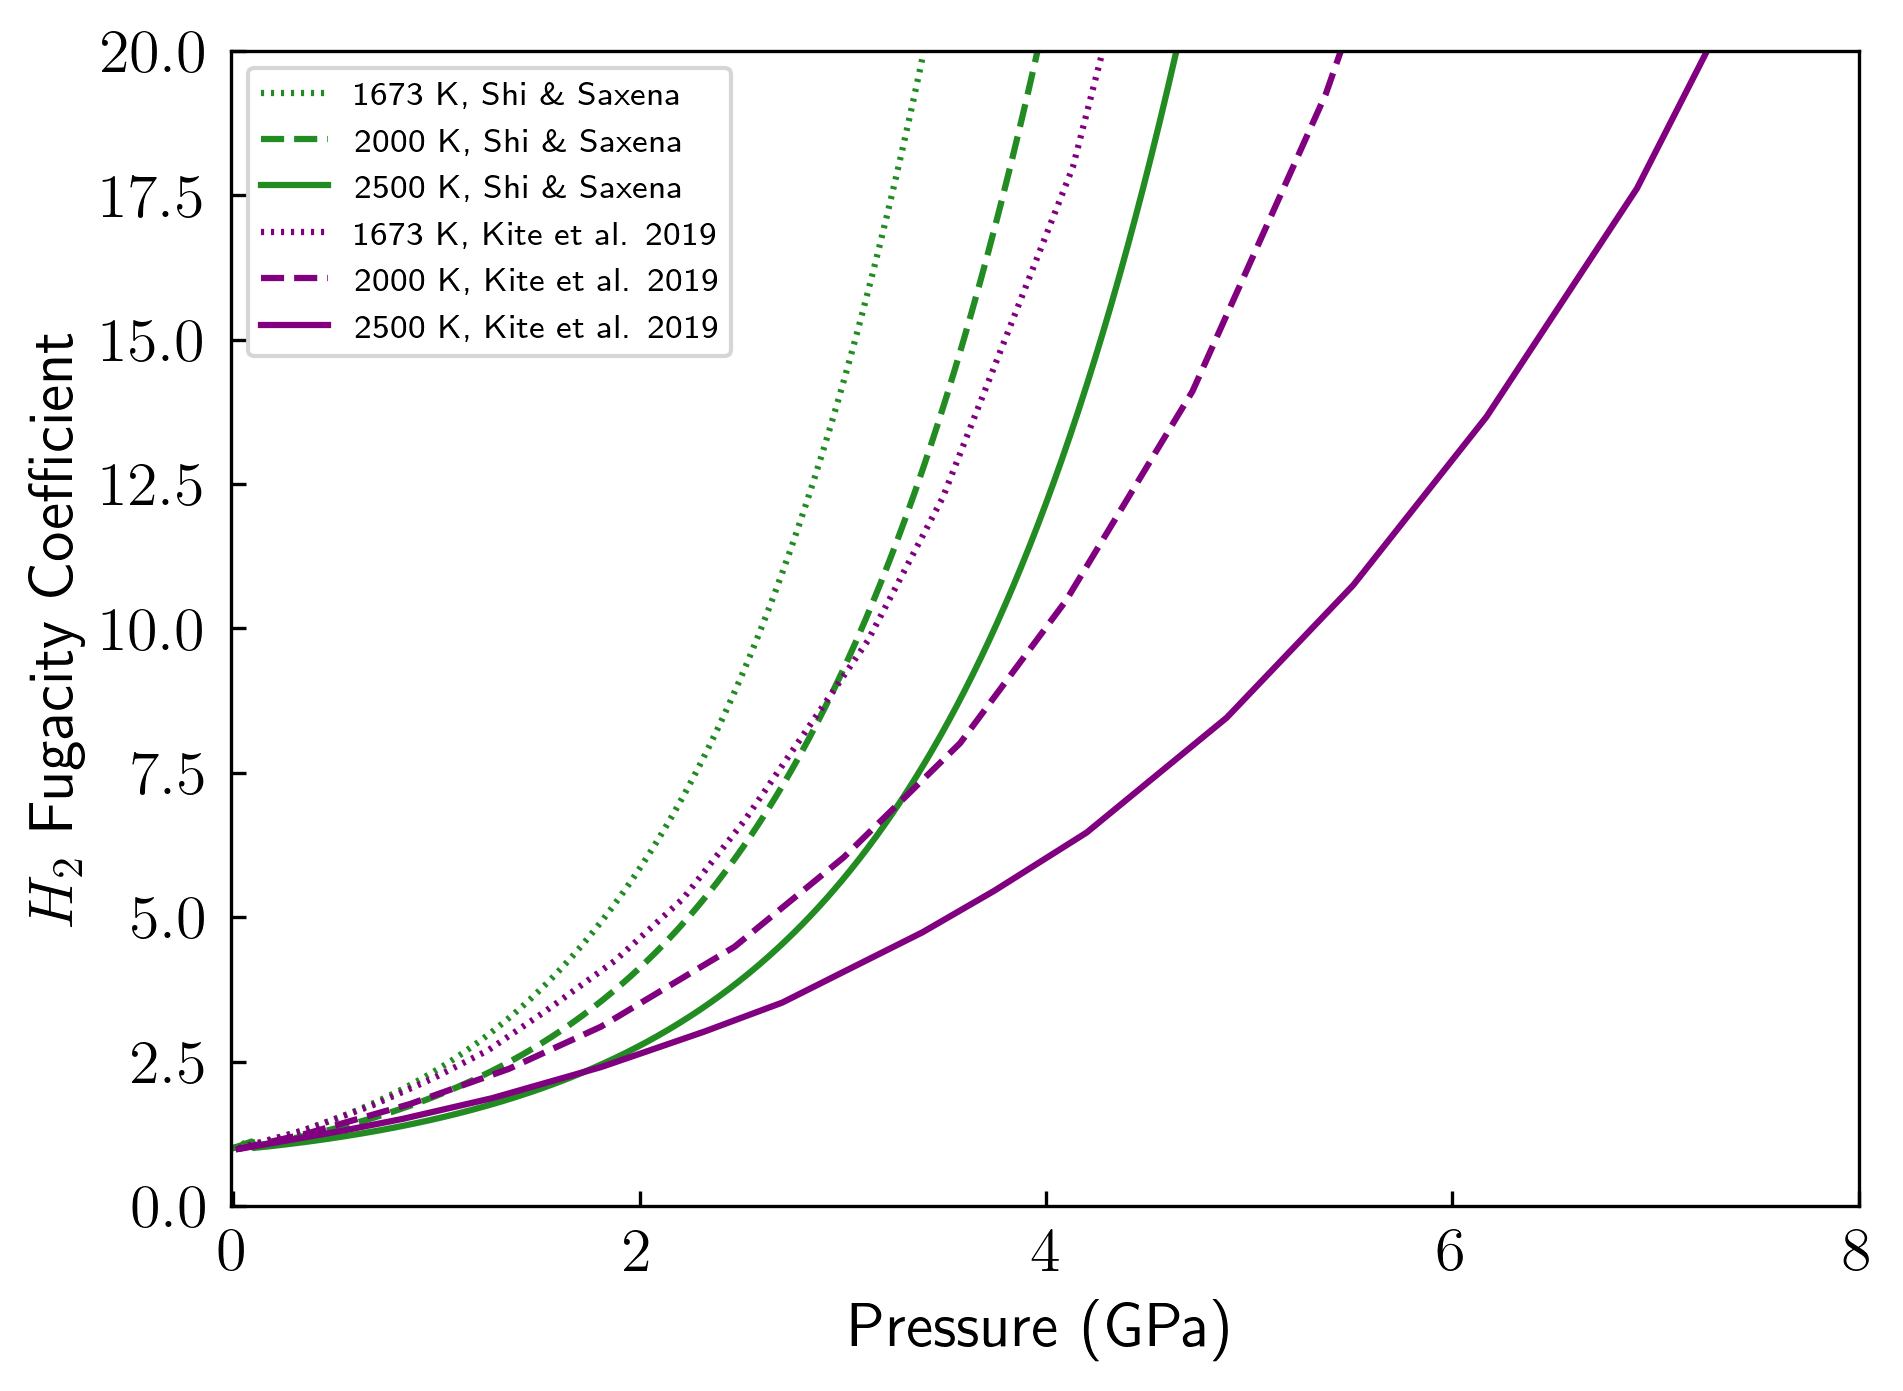

In [24]:
fig,ax = plt.subplots()
#plt.plot(pressure_arr/1e4, HP_1673, color='dodgerblue', linestyle='dotted', label=r'1673 K, Holland \& Powell')
#plt.plot(pressure_arr/1e4, HP_2000, color='dodgerblue', linestyle='--', label=r'2000 K, Holland \& Powell')
#plt.plot(pressure_arr/1e4, HP_2500, color='dodgerblue', label=r'2500 K, Holland \& Powell')

plt.plot(pressure_arr/1e4, SS_1673, color='forestgreen', linestyle='dotted', label=r'1673 K, Shi \& Saxena')
plt.plot(pressure_arr/1e4, SS_2000, color='forestgreen', linestyle='--', label=r'2000 K, Shi \& Saxena')
plt.plot(pressure_arr/1e4, SS_2500, color='forestgreen', label=r'2500 K, Shi \& Saxena')

plt.plot(K19_1673_df['P_GPa'], K19_1673_df['H2_fc'], color='purple', linestyle='dotted', label=r'1673 K, Kite et al. 2019')
plt.plot(K19_2000_df['P_GPa'], K19_2000_df['H2_fc'], color='purple', linestyle='--', label=r'2000 K, Kite et al. 2019')
plt.plot(K19_2500_df['P_GPa'], K19_2500_df['H2_fc'], color='purple', label=r'2500 K, Kite et al. 2019')

plt.legend(fontsize=8)
plt.ylim(0, 20)
plt.xlim(-0.01, 8)
#plt.xscale('log')
plt.xlabel('Pressure (GPa)')
plt.ylabel(r'$H_2$ Fugacity Coefficient')
plt.savefig('data/Plots/H2_FugacityCoefficients_KitvsShiSaxena.jpg', dpi=1000)
plt.show()

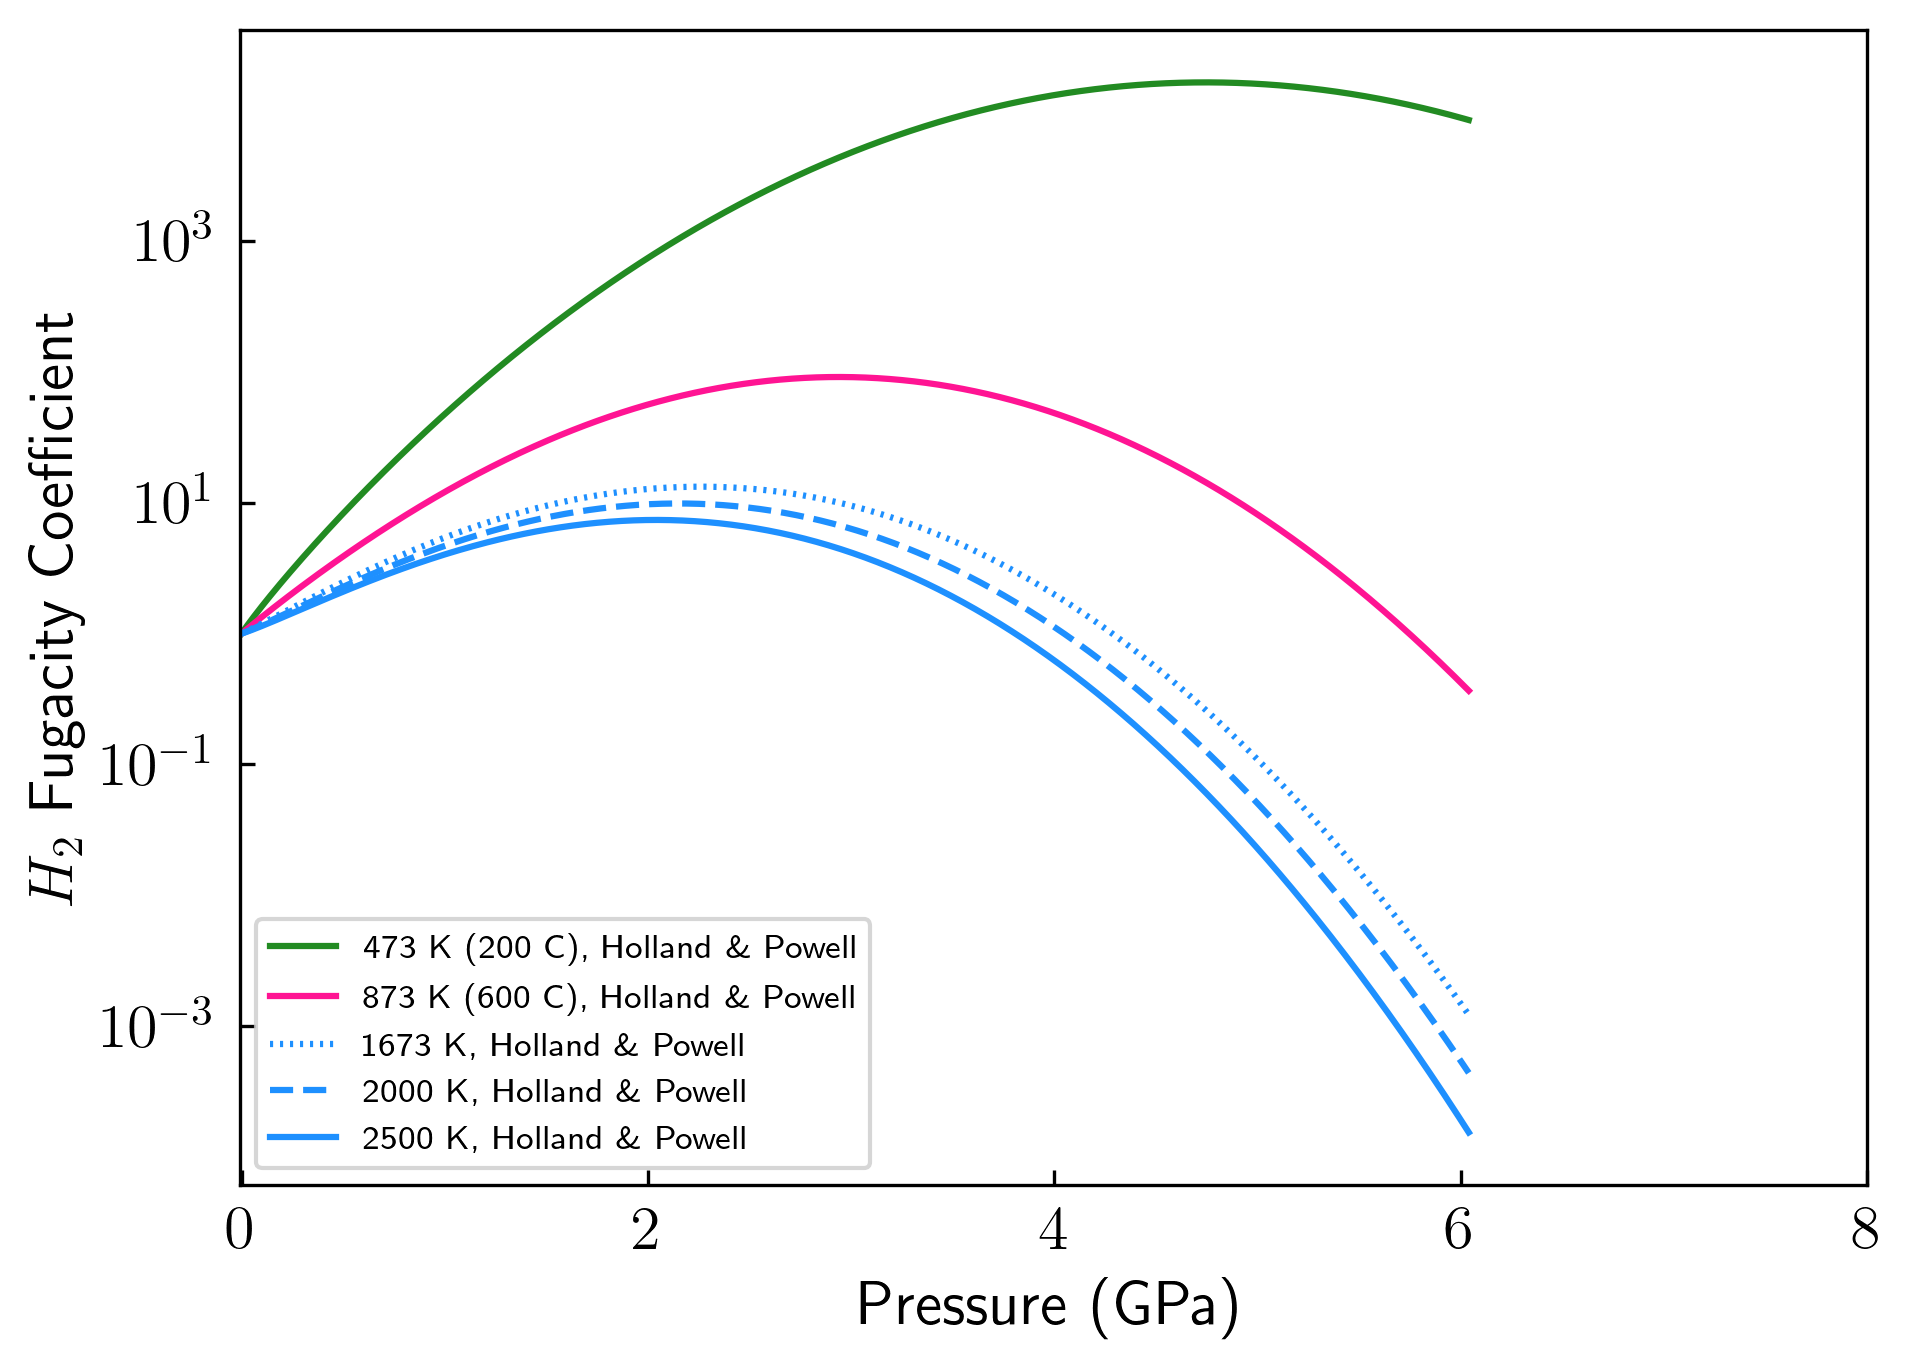

In [36]:
fig,ax = plt.subplots()
plt.plot(pressure_arr/1e4, HP_473, color='forestgreen', label=r'473 K (200 C), Holland \& Powell')
plt.plot(pressure_arr/1e4, HP_873, color='deeppink', label=r'873 K (600 C), Holland \& Powell')

plt.plot(pressure_arr/1e4, HP_1673, color='dodgerblue', linestyle='dotted', label=r'1673 K, Holland \& Powell')
plt.plot(pressure_arr/1e4, HP_2000, color='dodgerblue', linestyle='--', label=r'2000 K, Holland \& Powell')
plt.plot(pressure_arr/1e4, HP_2500, color='dodgerblue', label=r'2500 K, Holland \& Powell')

plt.legend(fontsize=8)
#plt.ylim(0, 20)
plt.xlim(-0.01, 8)
plt.yscale('log')
#plt.xscale('log')
plt.xlabel('Pressure (GPa)')
plt.ylabel(r'$H_2$ Fugacity Coefficient')
#plt.savefig('H2_FugacityCoefficients_ModelComparisons.jpg', dpi=1000)
plt.show()

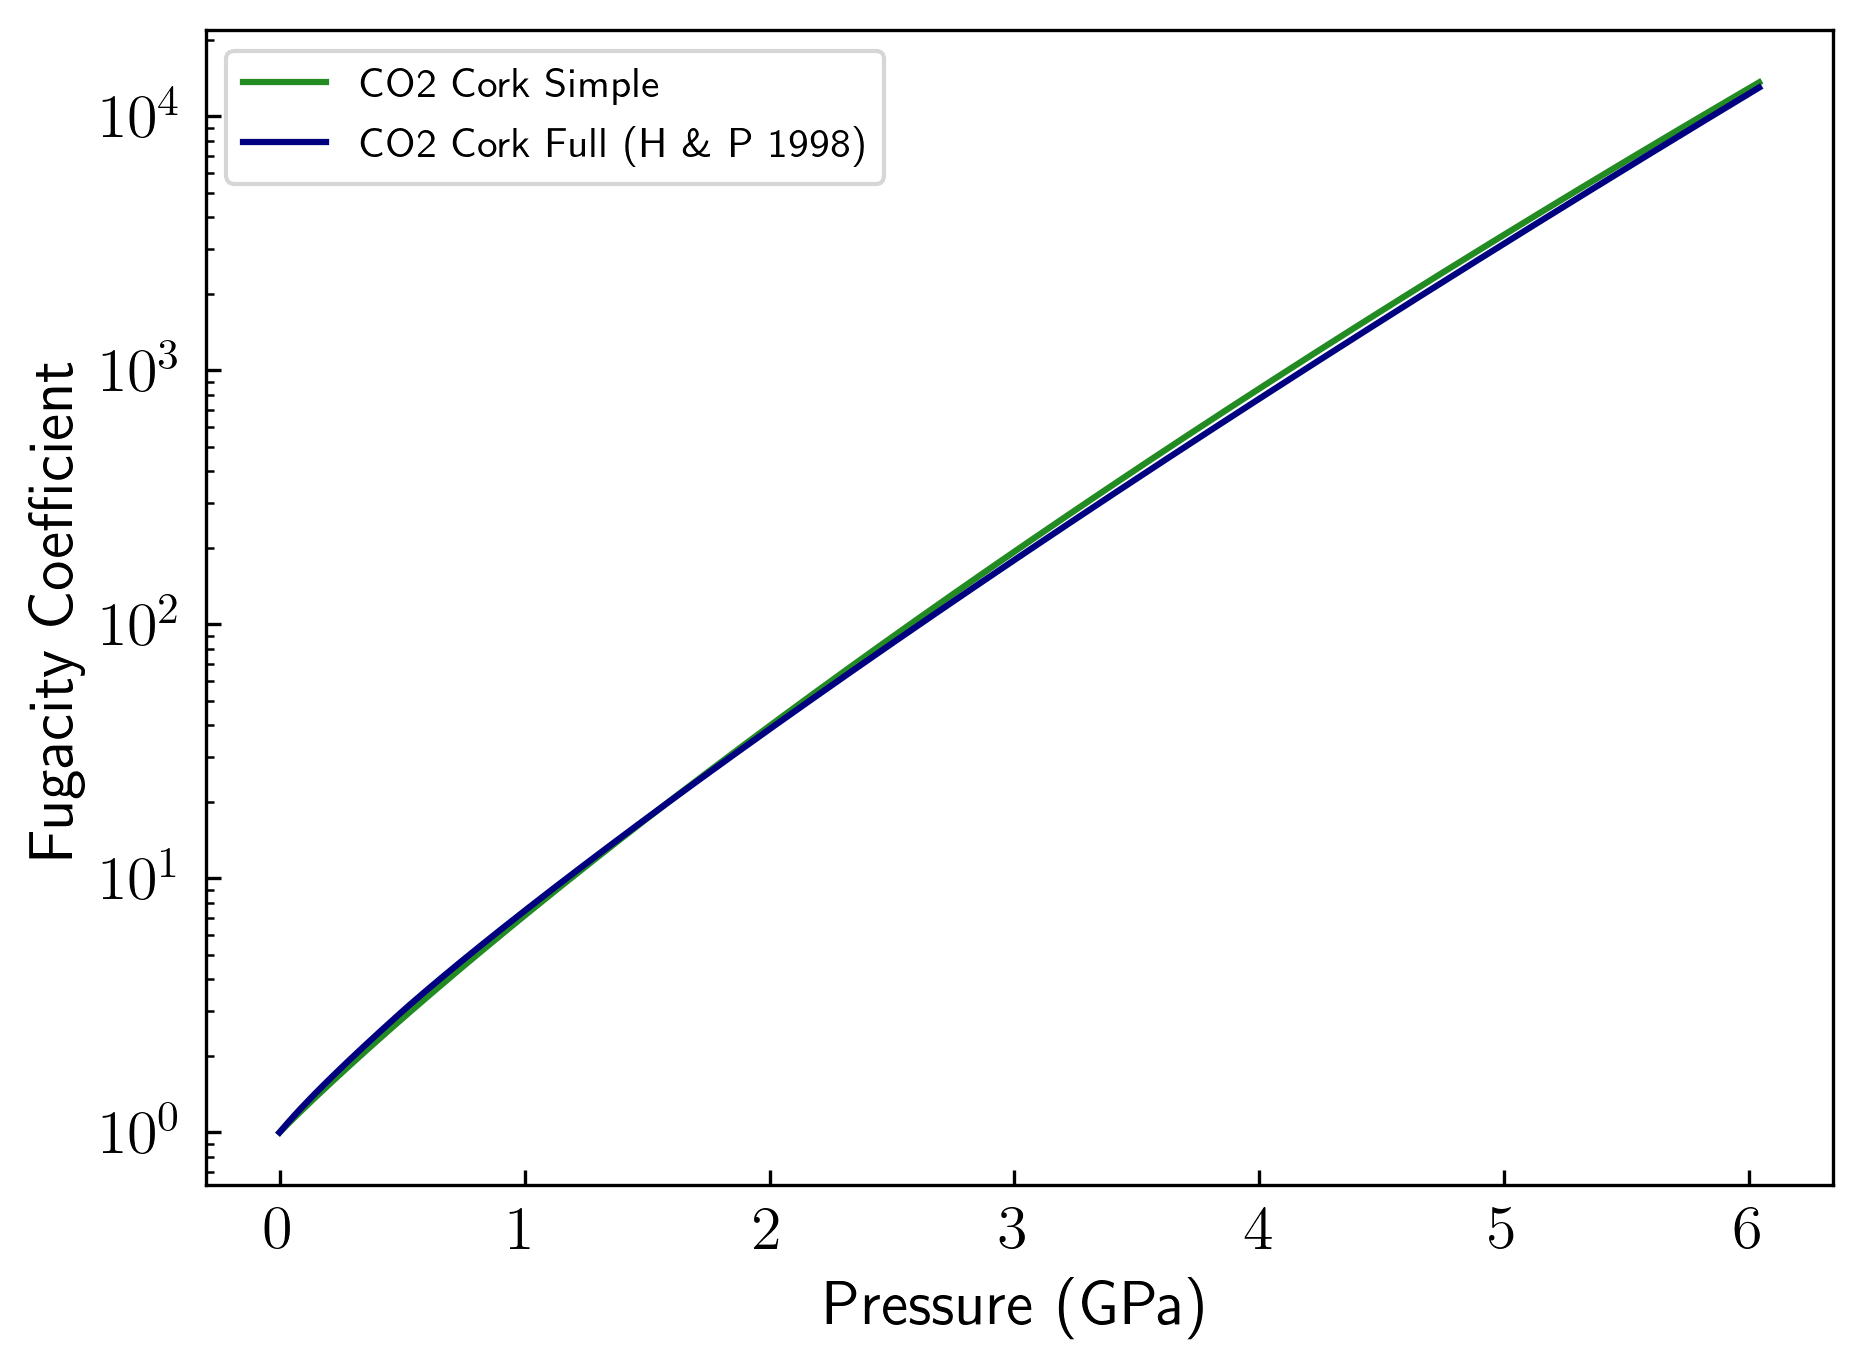

In [49]:
fig, ax = plt.subplots()
plt.plot(pressure_arr/1e4, HP_2000_CO2Simple, color='forestgreen', label='CO2 Cork Simple')
plt.plot(pressure_arr/1e4, HP_2000_CO2Full, color='navy', label=r'CO2 Cork Full (H \& P 1998)')
#plt.plot(pressure_arr/1e4, HP_2000_CO2FullUp, color='violet', label=r'CO2 Cork Full (with Updated Virial Coeffs H \& P 1998)')

plt.legend(fontsize=10)
#plt.ylim(0, 100)
plt.yscale('log')
plt.xlabel('Pressure (GPa)')
plt.ylabel(r'Fugacity Coefficient')
plt.savefig('CO2_SimplevsFullCork.jpg', dpi=1000)
plt.show()

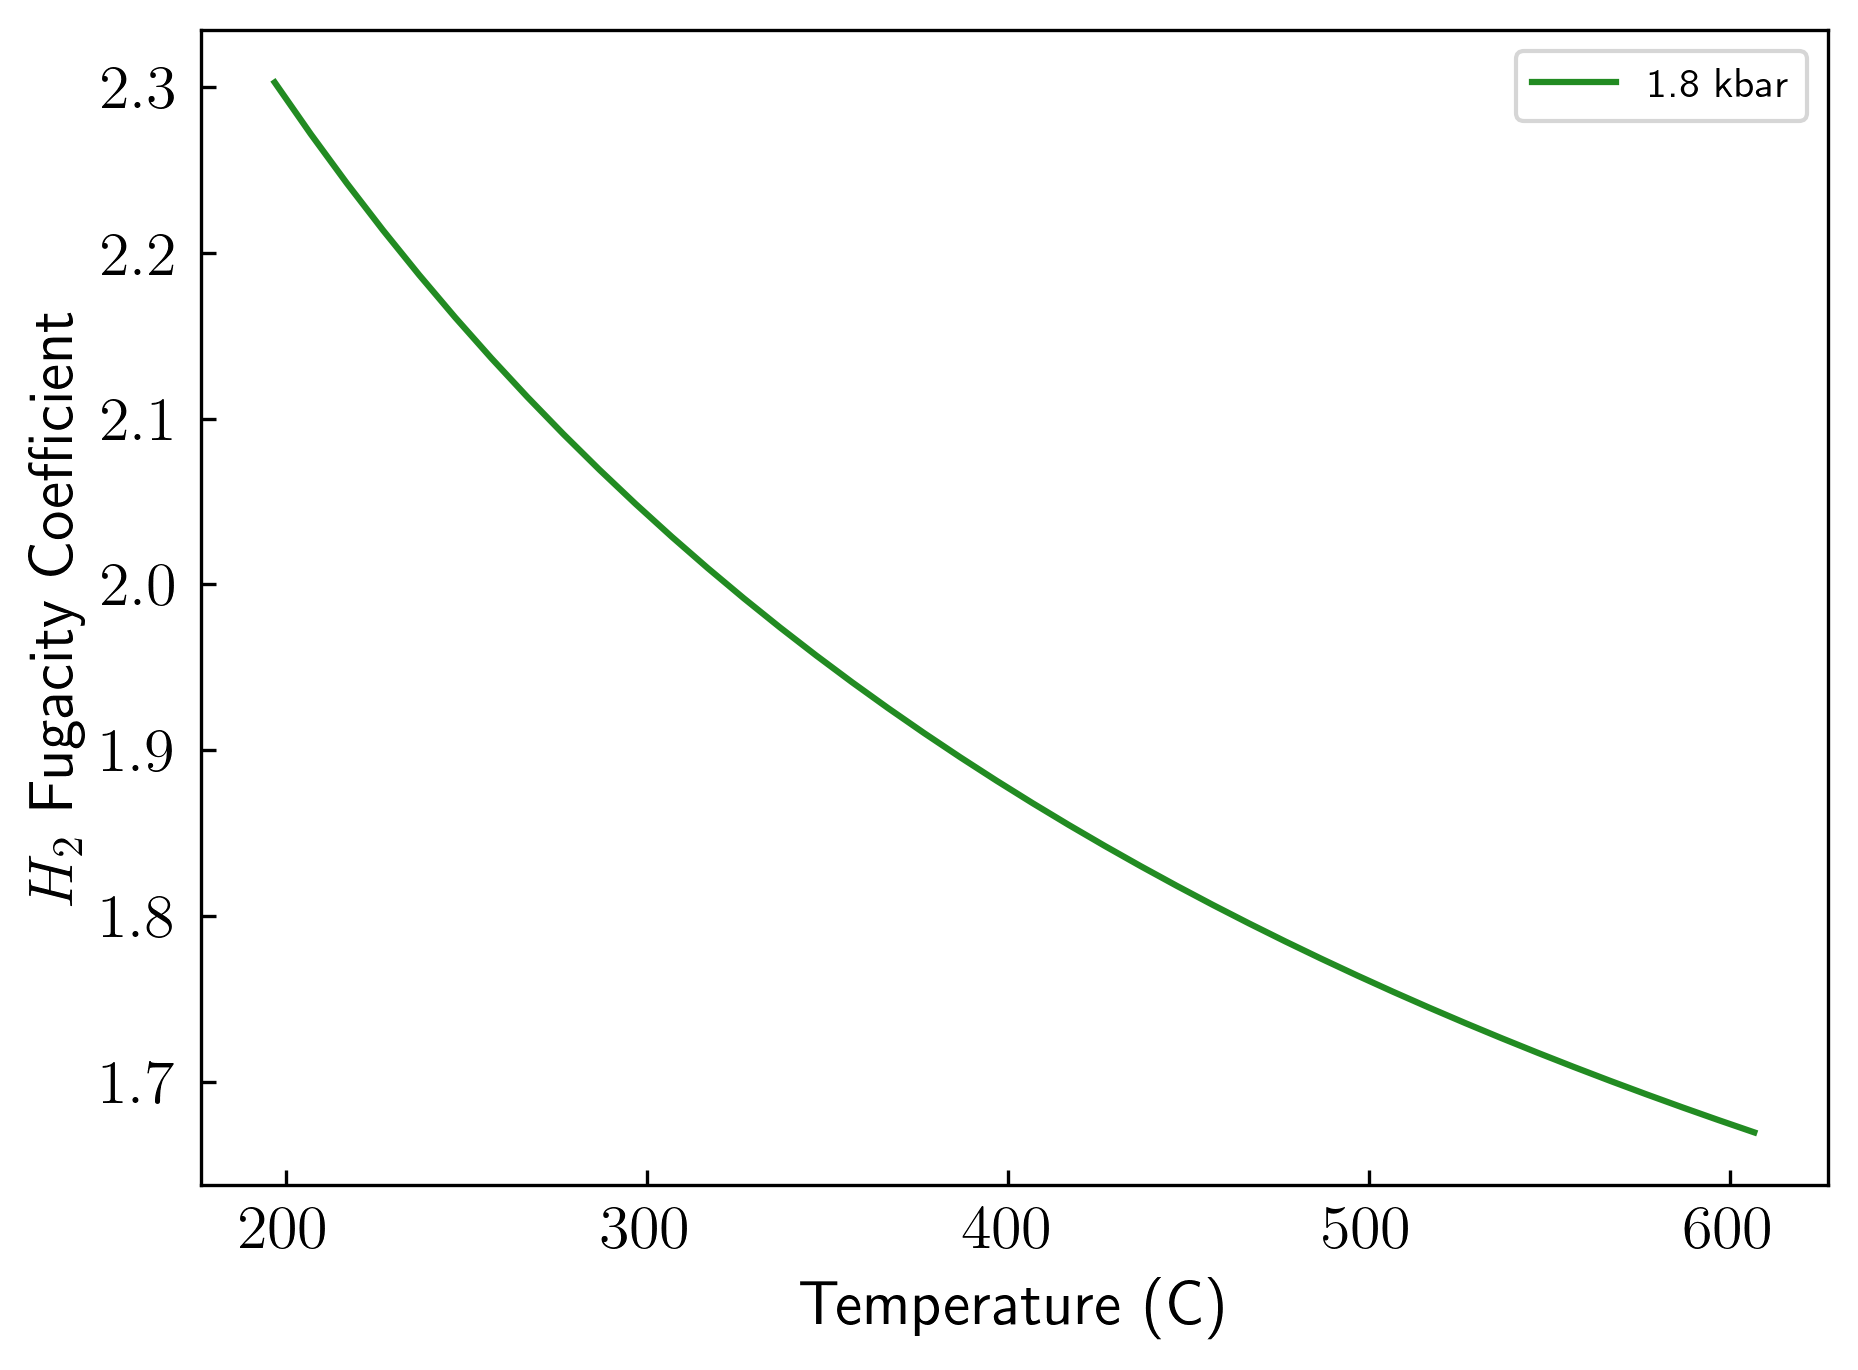

In [38]:
fig, ax = plt.subplots()
plt.plot(temp_arr-273.15, HP_1p8kbar, color='forestgreen', label='1.8 kbar')

plt.legend(fontsize=10)

plt.xlabel('Temperature (C)')
plt.ylabel(r'$H_2$ Fugacity Coefficient')
plt.savefig('H2_1p8kbar.jpg', dpi=1000)
plt.show()

In [ ]:
print(HP_1p8kbar)

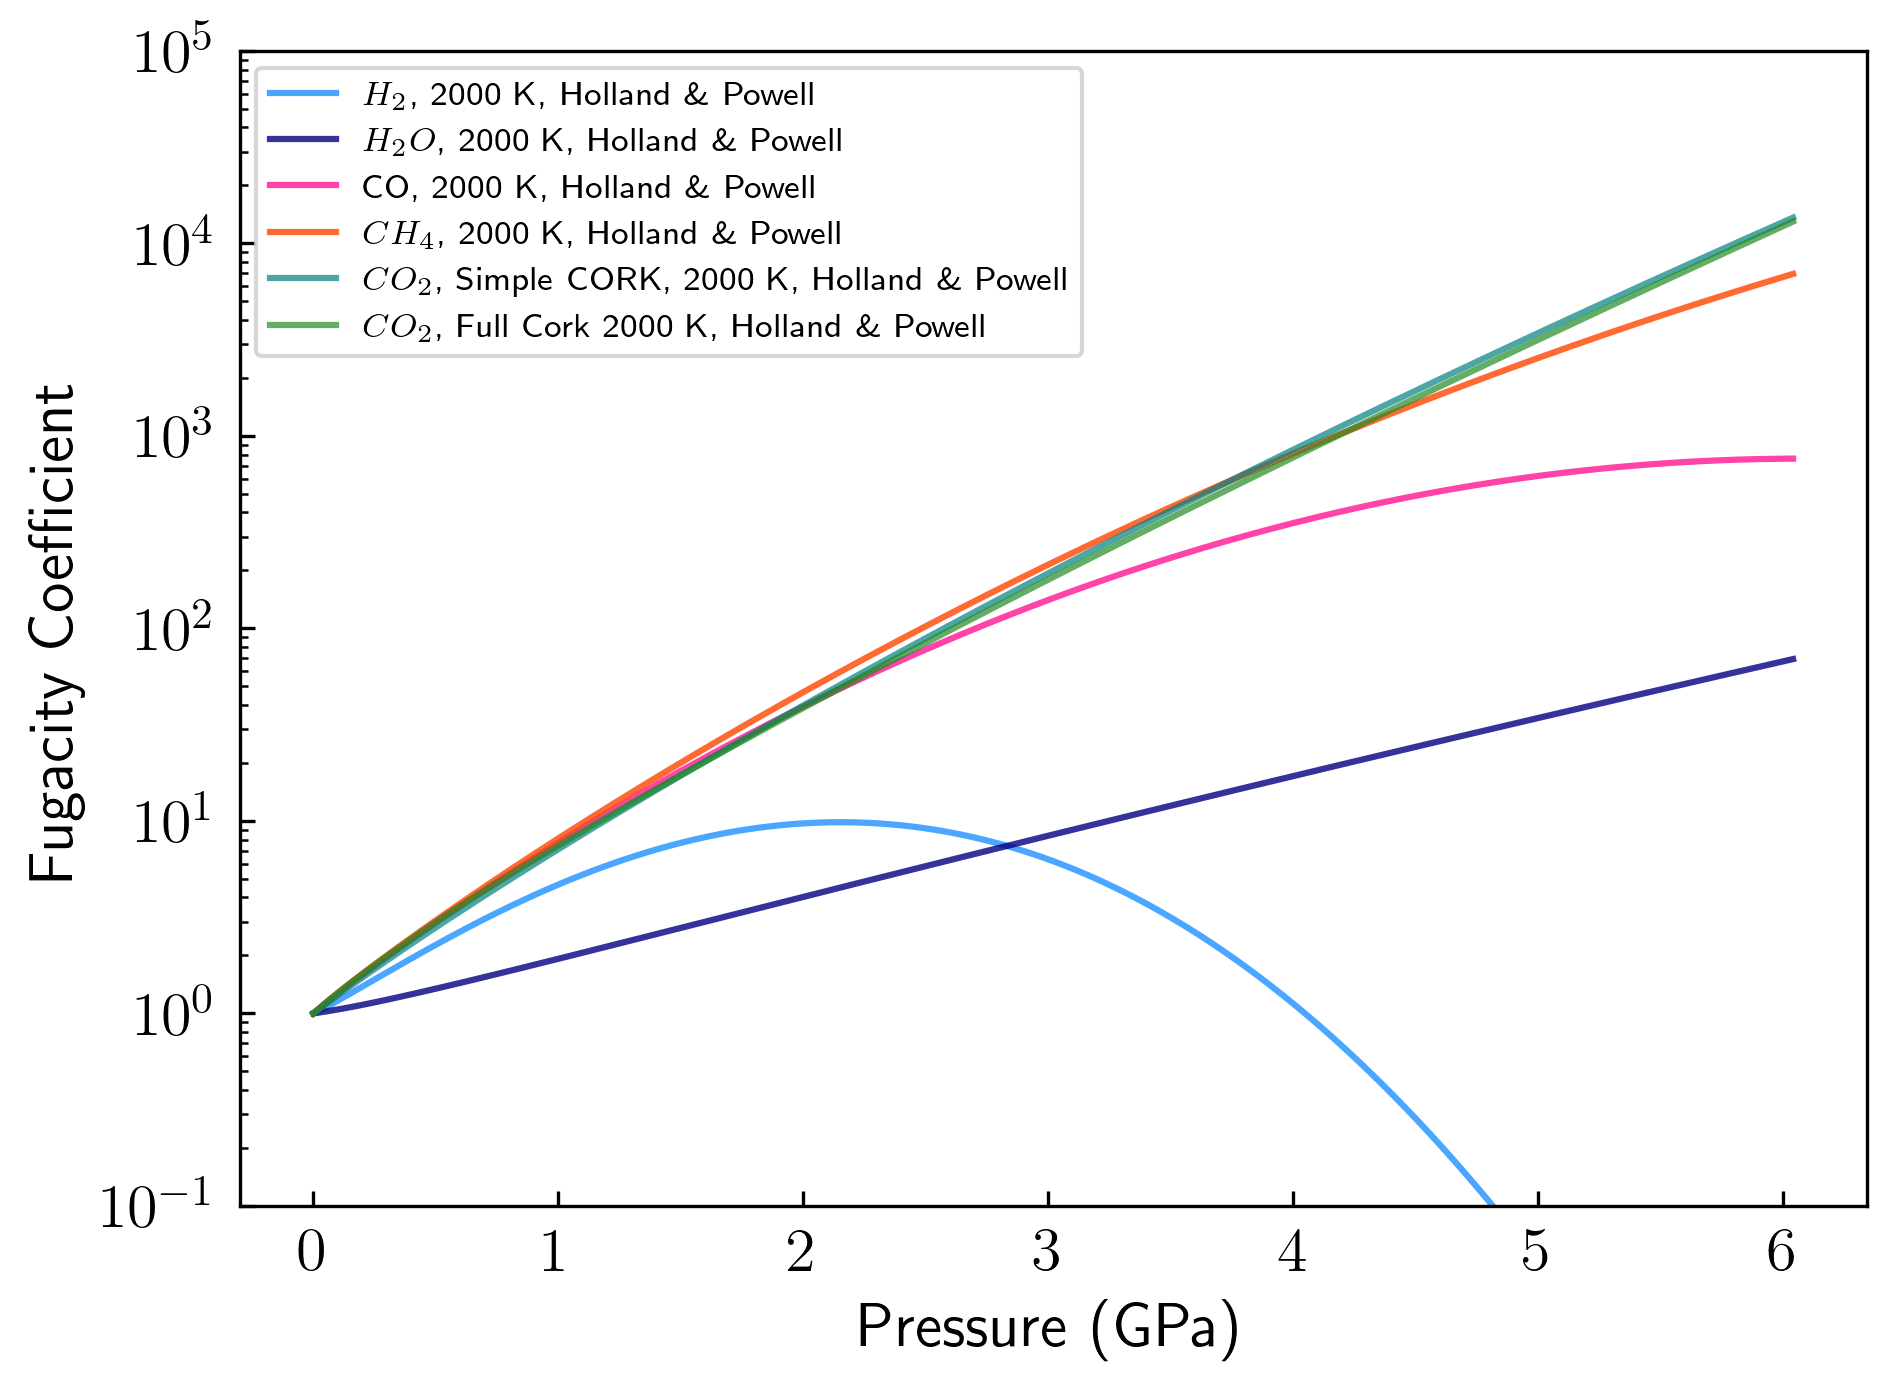

In [47]:
fig,ax = plt.subplots()
#plt.plot(pressure_arr/1e4, HP_1673, color='dodgerblue', linestyle='dotted', label=r'$H_2$, 1673 K, Holland \& Powell')
plt.plot(pressure_arr/1e4, HP_2000, color='dodgerblue', alpha=0.8, label=r'$H_2$, 2000 K, Holland \& Powell')
#plt.plot(pressure_arr/1e4, HP_2500, color='dodgerblue', label=r'$H_2$, 2500 K, Holland \& Powell')
plt.plot(pressure_arr/1e4, HP_2000_H2O, color='navy', alpha=0.8, label=r'$H_2O$, 2000 K, Holland \& Powell')

#plt.plot(pressure_arr/1e4, HP_1673_CO, color='violet', linestyle='dotted', label=r'CO, 1673 K, Holland \& Powell')
plt.plot(pressure_arr/1e4, HP_2000_CO, color='deeppink', alpha=0.8, label=r'CO, 2000 K, Holland \& Powell')

plt.plot(pressure_arr/1e4, HP_2000_CH4, color='orangered',  alpha=0.8, label=r'$CH_4$, 2000 K, Holland \& Powell')
plt.plot(pressure_arr/1e4, HP_2000_CO2Simple, color='teal', alpha=0.7, label=r'$CO_2$, Simple CORK, 2000 K, Holland \& Powell')
plt.plot(pressure_arr/1e4, HP_2000_CO2Full, color='forestgreen', alpha=0.7,  label=r'$CO_2$, Full Cork 2000 K, Holland \& Powell')


plt.legend(fontsize=8)
plt.yscale('log')
plt.ylim(0.1, 1e5)
#plt.xlim(-0.01, 8)
#plt.xscale('log')
plt.xlabel('Pressure (GPa)')
plt.ylabel(r'Fugacity Coefficient')
plt.savefig('FugacityCoefficients_HP_VariousCorrespondingStates.jpg', dpi=1000)
plt.show()

In [ ]:
print(HP_2000_CO2)

#### Shi & Saxena Plots

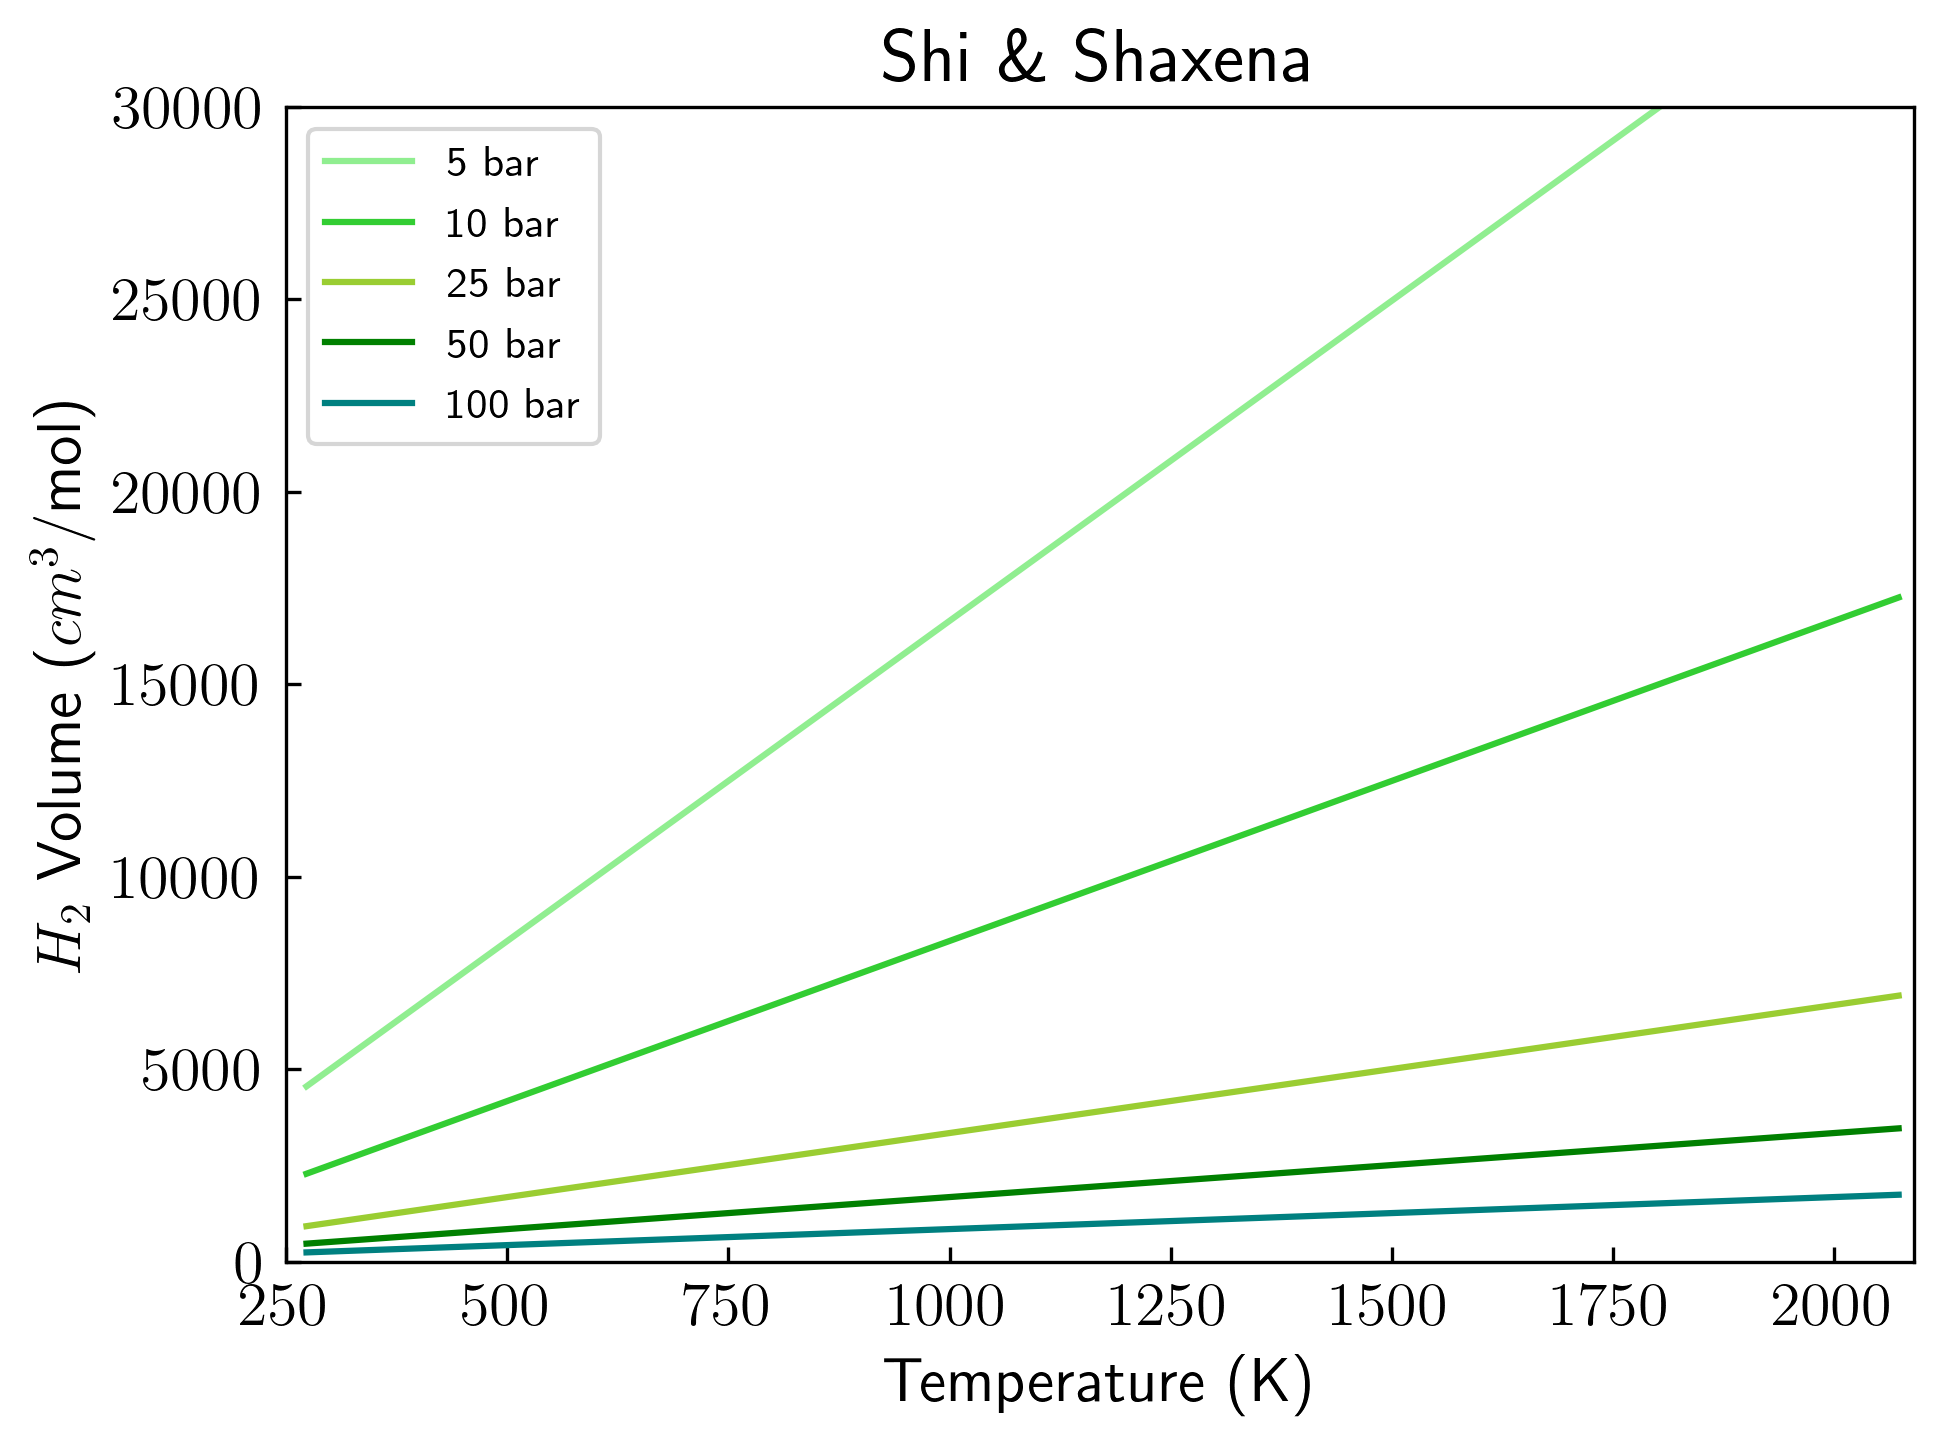

In [8]:
fig,ax = plt.subplots()
plt.plot(temp_arr_SF, SS_model_5bar, color='lightgreen', label=r'5 bar')
plt.plot(temp_arr_SF, SS_model_10bar, color='limegreen', label=r'10 bar')
plt.plot(temp_arr_SF, SS_model_25bar, color='yellowgreen', label=r'25 bar')
plt.plot(temp_arr_SF, SS_model_50bar, color='green', label=r'50 bar')
plt.plot(temp_arr_SF, SS_model_100bar, color='teal', label=r'100 bar')

plt.legend(fontsize='x-small')
plt.xlabel('Temperature (K)')
plt.ylim(0, 30000)
plt.xlim(250, 2090)
plt.ylabel(r'$H_2$ Volume ($cm^3$/mol)')
plt.title(r'Shi \& Shaxena')
#plt.savefig('VolumevsT_ShiSaxena.jpg', dpi=1000)
plt.show()

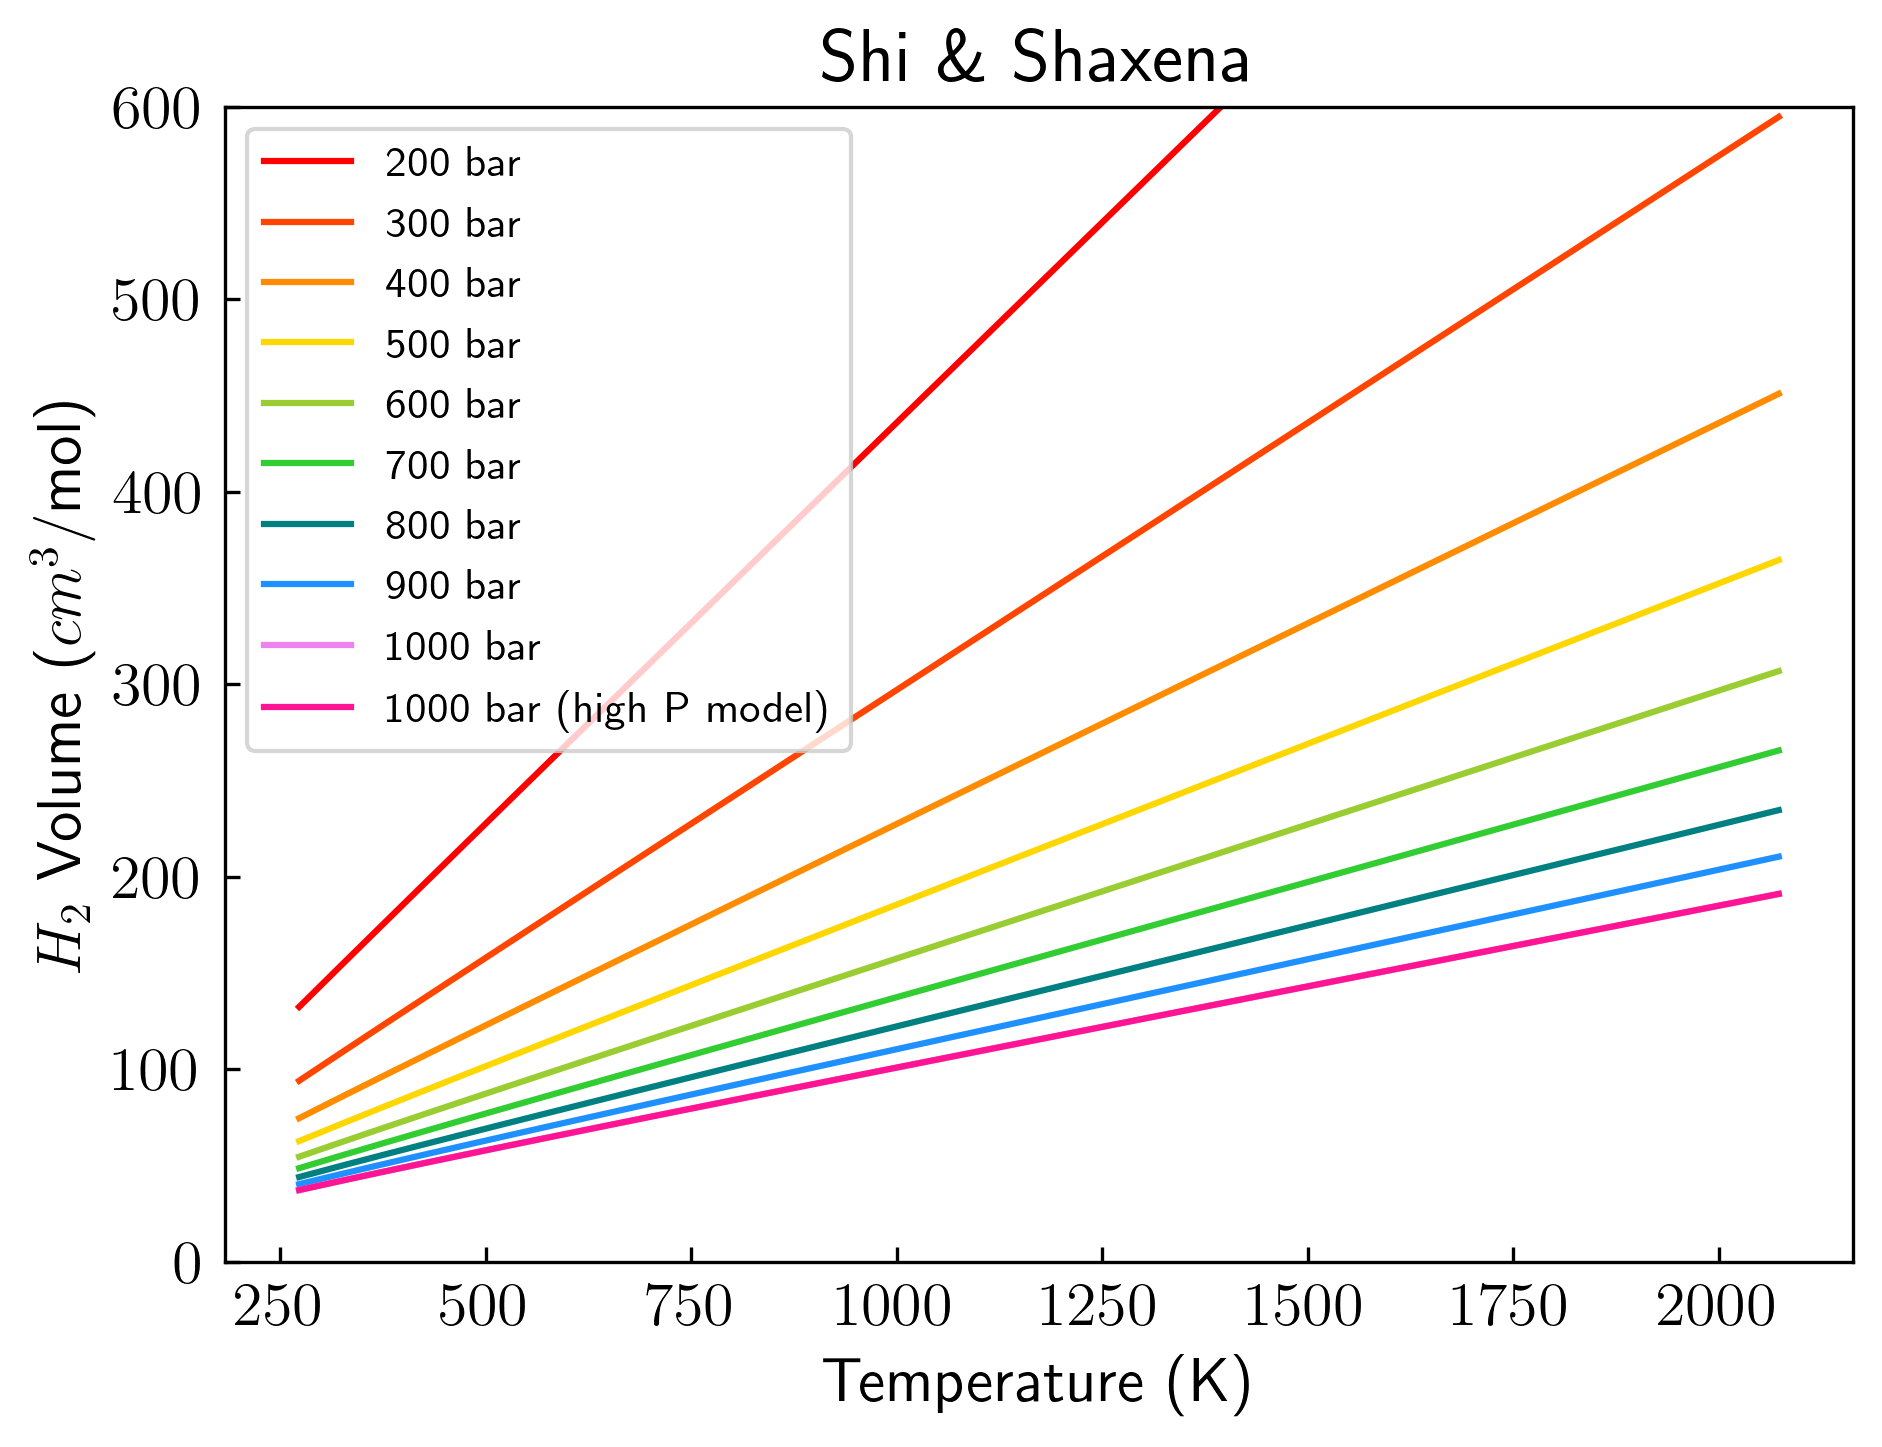

In [9]:
fig,ax = plt.subplots()
plt.plot(temp_arr_SF, SS_model_200bar, color='red', label=r'200 bar')
plt.plot(temp_arr_SF, SS_model_300bar, color='orangered', label=r'300 bar')
plt.plot(temp_arr_SF, SS_model_400bar, color='darkorange', label=r'400 bar')
plt.plot(temp_arr_SF, SS_model_500bar, color='gold', label=r'500 bar')
plt.plot(temp_arr_SF, SS_model_600bar, color='yellowgreen', label=r'600 bar')
plt.plot(temp_arr_SF, SS_model_700bar, color='limegreen', label=r'700 bar')
plt.plot(temp_arr_SF, SS_model_800bar, color='teal', label=r'800 bar')
plt.plot(temp_arr_SF, SS_model_900bar, color='dodgerblue', label=r'900 bar')
plt.plot(temp_arr_SF, SS_model_1000bar, color='violet', label=r'1000 bar')
plt.plot(temp_arr_SF, SS_model_1000bar, color='deeppink', label=r'1000 bar (high P model)')

plt.legend(fontsize='x-small')
plt.xlabel('Temperature (K)')
plt.ylim(0, 600)
#plt.xlim(250, 2090)
plt.ylabel(r'$H_2$ Volume ($cm^3$/mol)')
plt.title(r'Shi \& Shaxena')
plt.savefig('VolumevsT_ShiSaxena_1b.jpg', dpi=1000)
plt.show()

In [12]:
print(SS_model_1000bar_hi)

[11.890941124528627, 1.0418646801495877, -5.10276569627642, -8.234888648510815, -9.328350285123218, -8.982708586363229, -7.586883000473645, -5.403911673516709, -2.61787269610334, 0.63869875785794, 4.26805692950606, 8.19661481195018, 12.367977812814502, 16.73824973073693, 21.272791955117984, 25.94393749989389, 30.72934756193737, 35.61080973115148, 40.57334561390476, 45.60453897795418, 50.694023527522404, 55.83308787770079, 61.01436769617072, 66.23160345010098, 71.47944807259093, 76.75331299895396, 82.04924397270327, 87.36382015049388, 92.69407159011352, 98.03741135300221, 103.39157930789736, 108.7545953654128, 114.12472036139323, 119.50042318020664, 124.88035299690816, 130.2633157406422, 135.64825405632496, 141.0342301790861, 146.42041124475418, 151.80605664631062, 157.19050711560948, 162.57317526549826, 167.95353737264708, 173.33112621810827, 178.70552483261096, 184.07636101817866, 189.4433025379086, 194.8060528824901, 200.16434753593649, 205.51795067457851, 210.86665224304173, 216.210

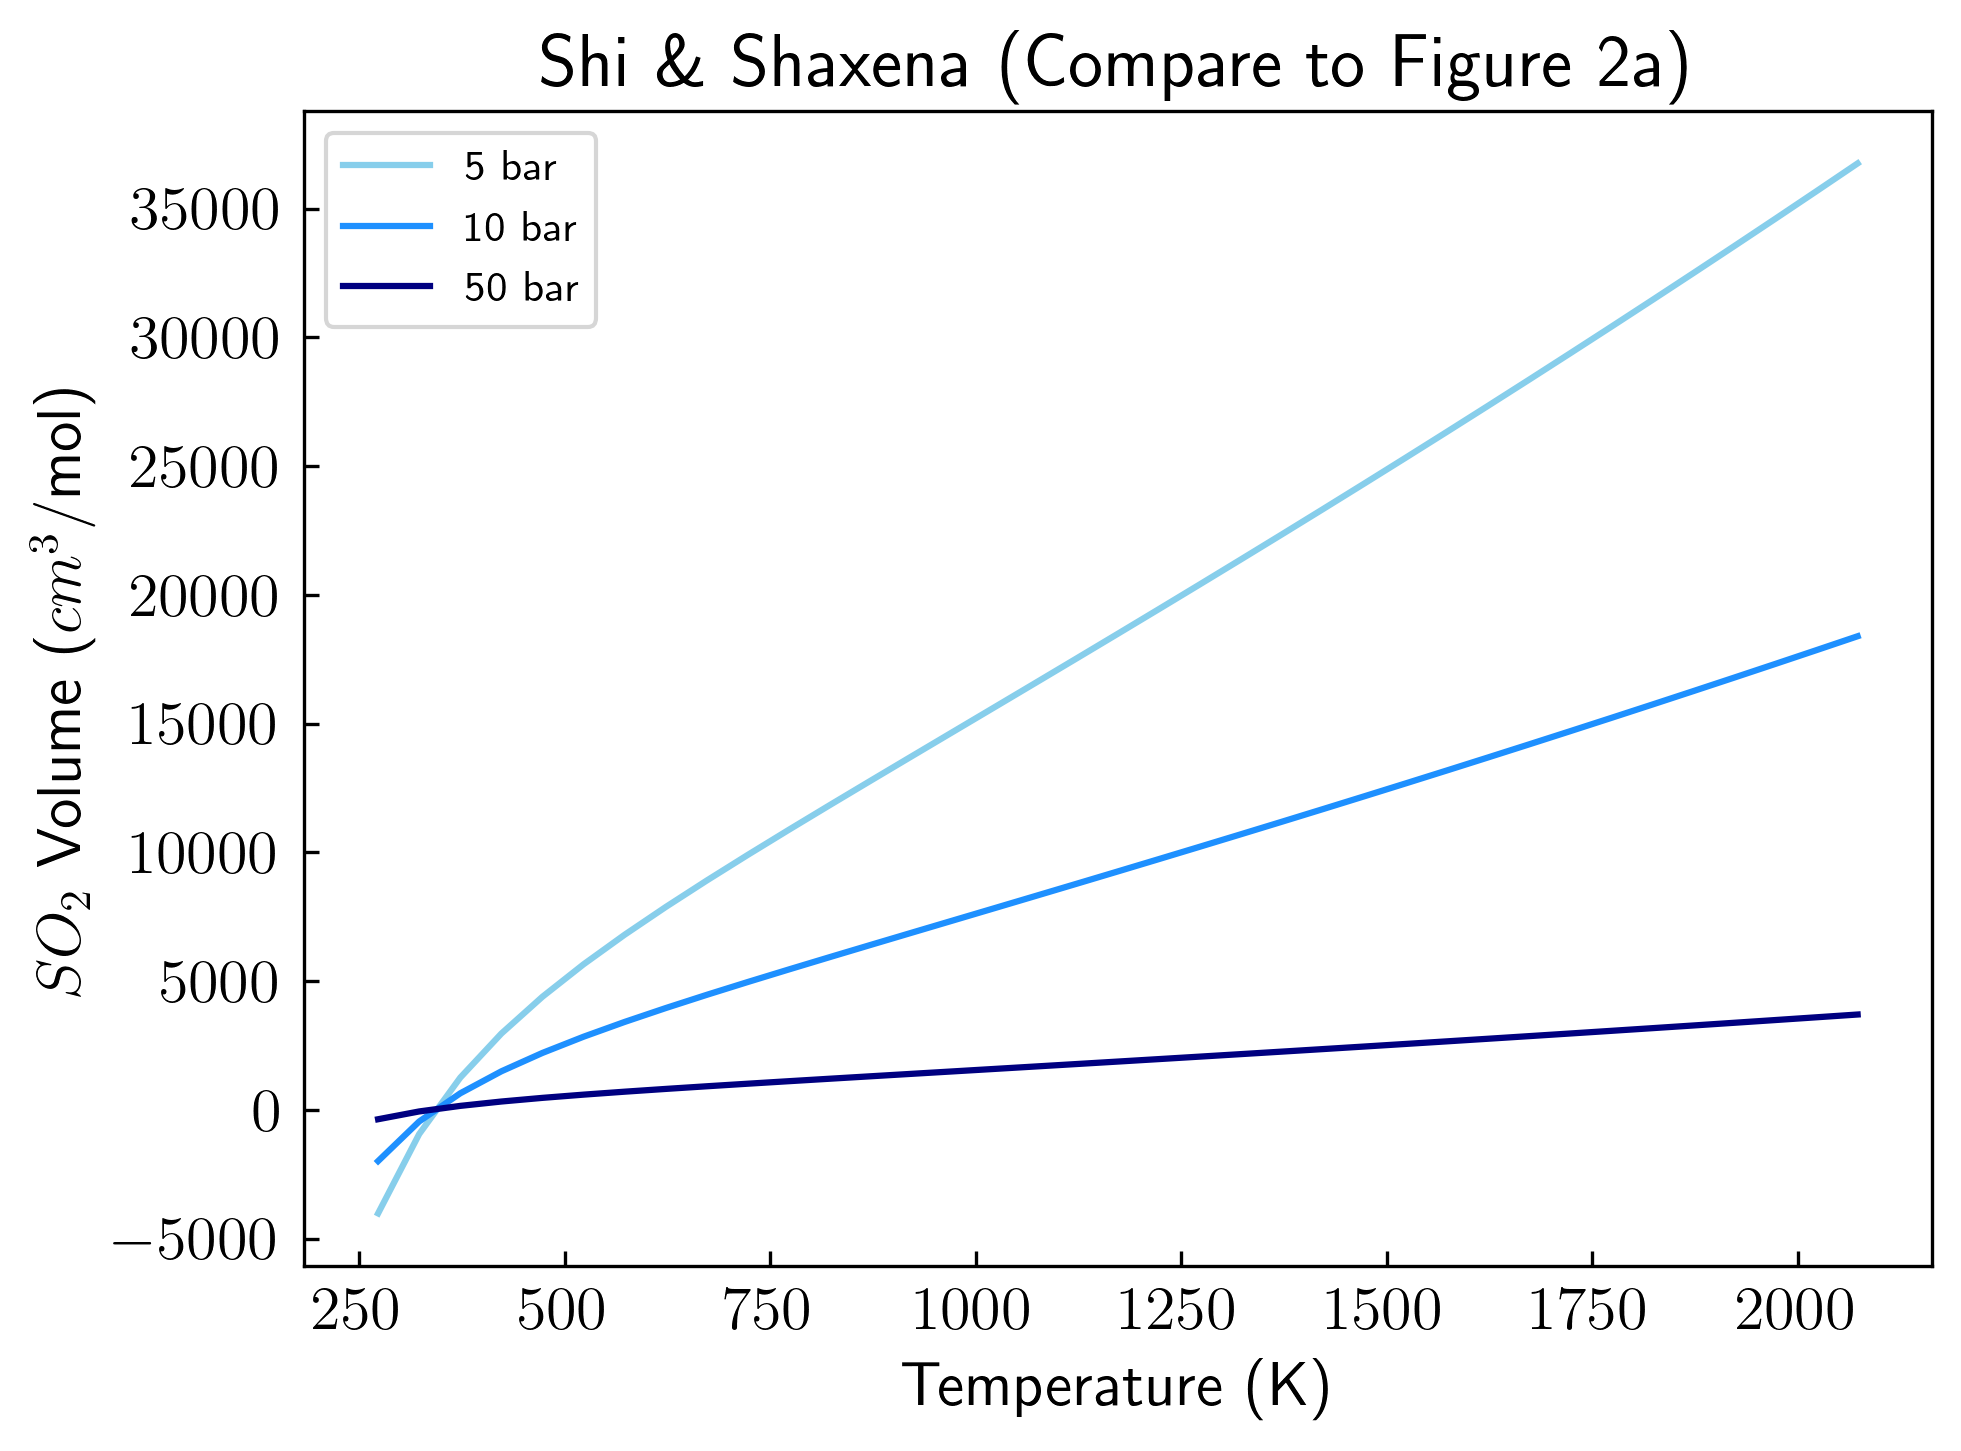

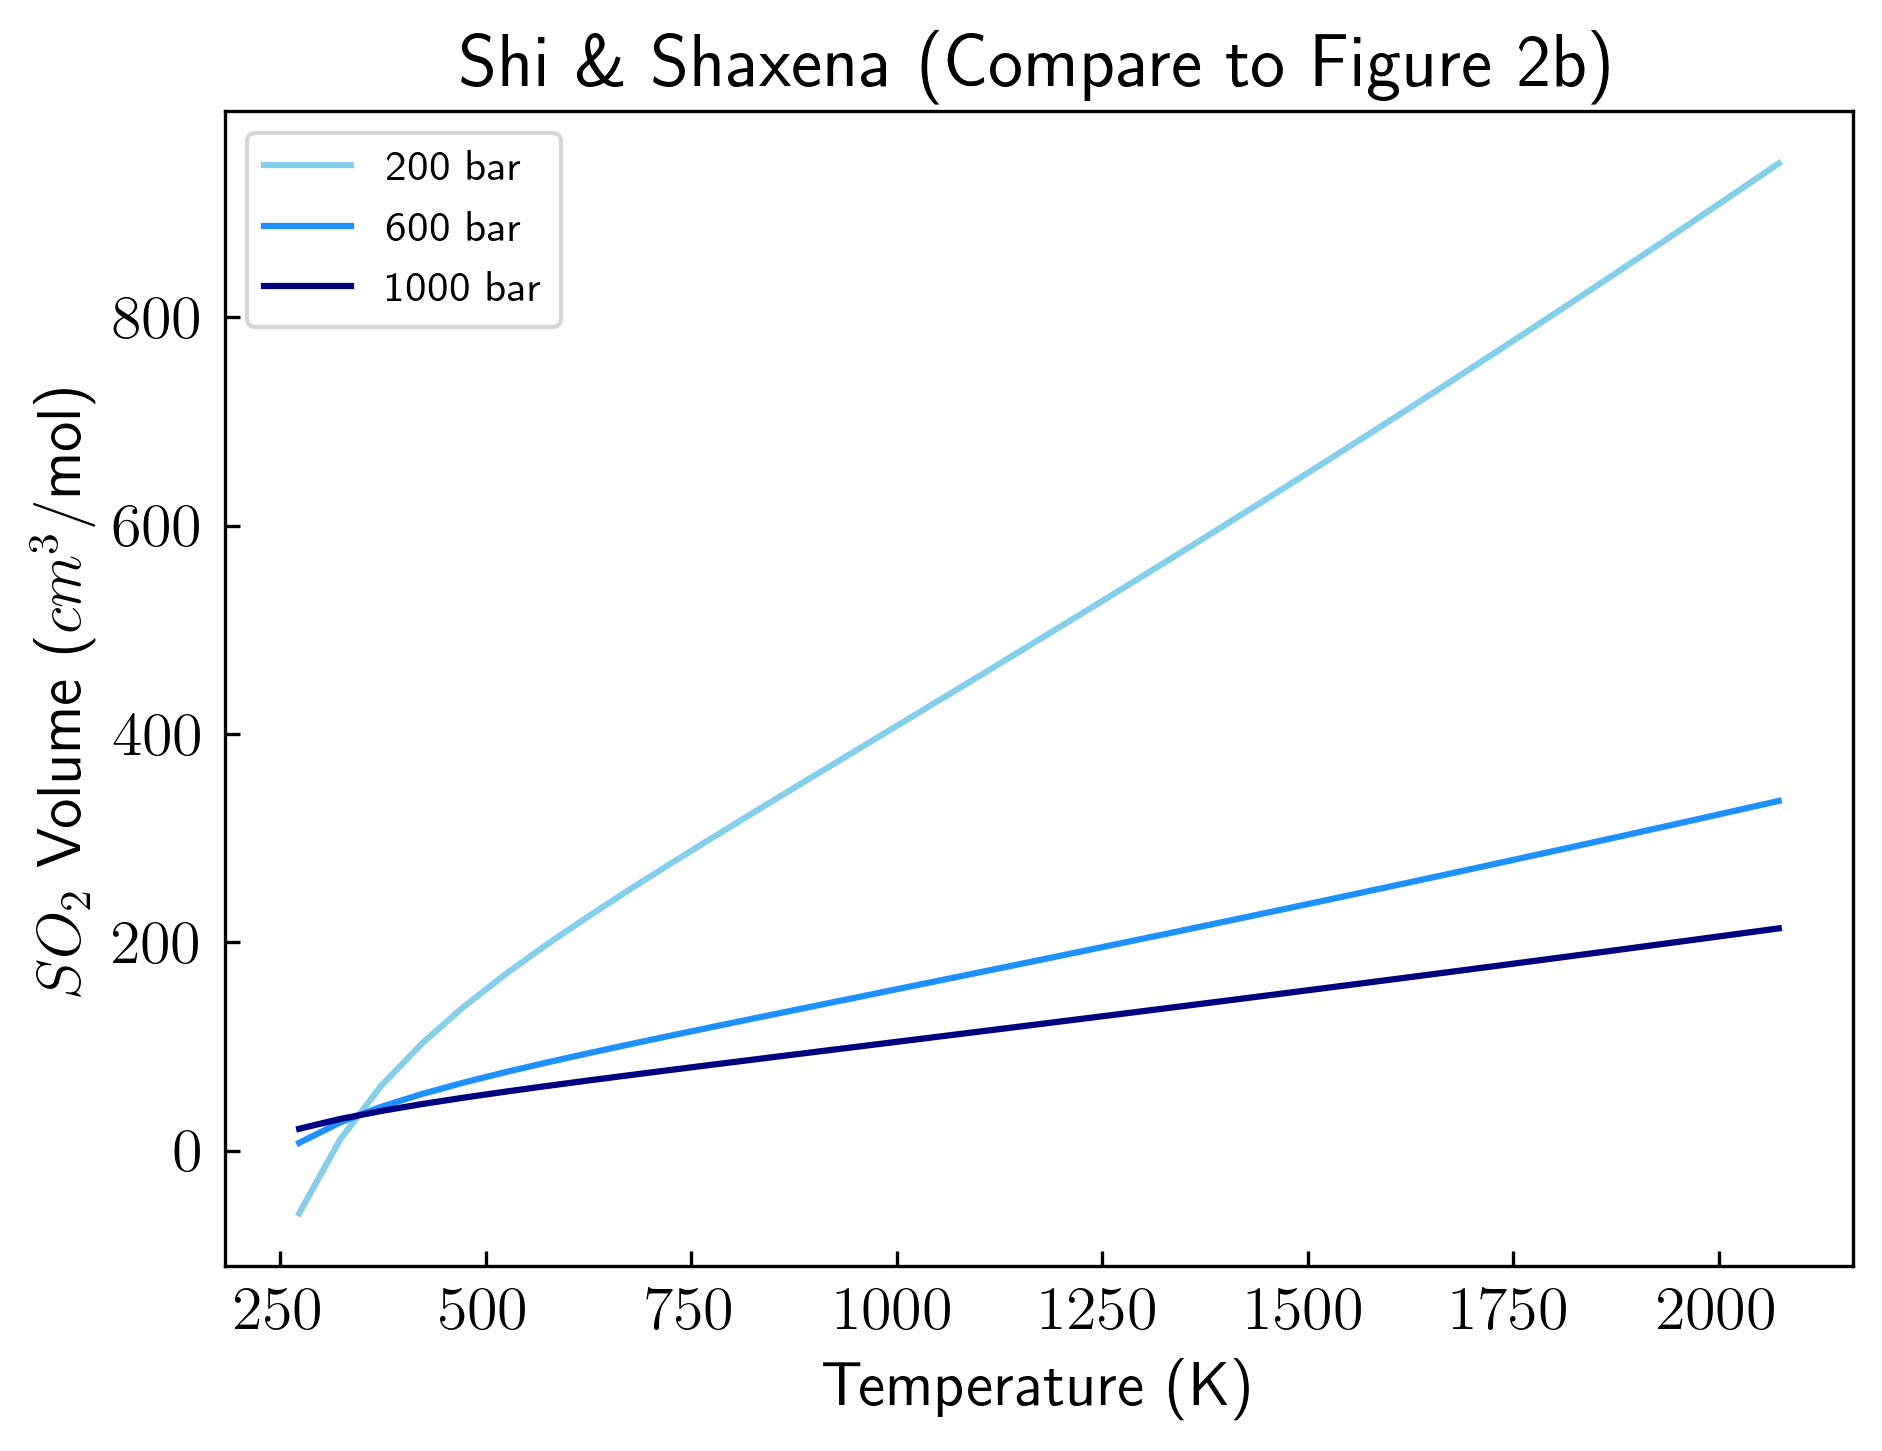

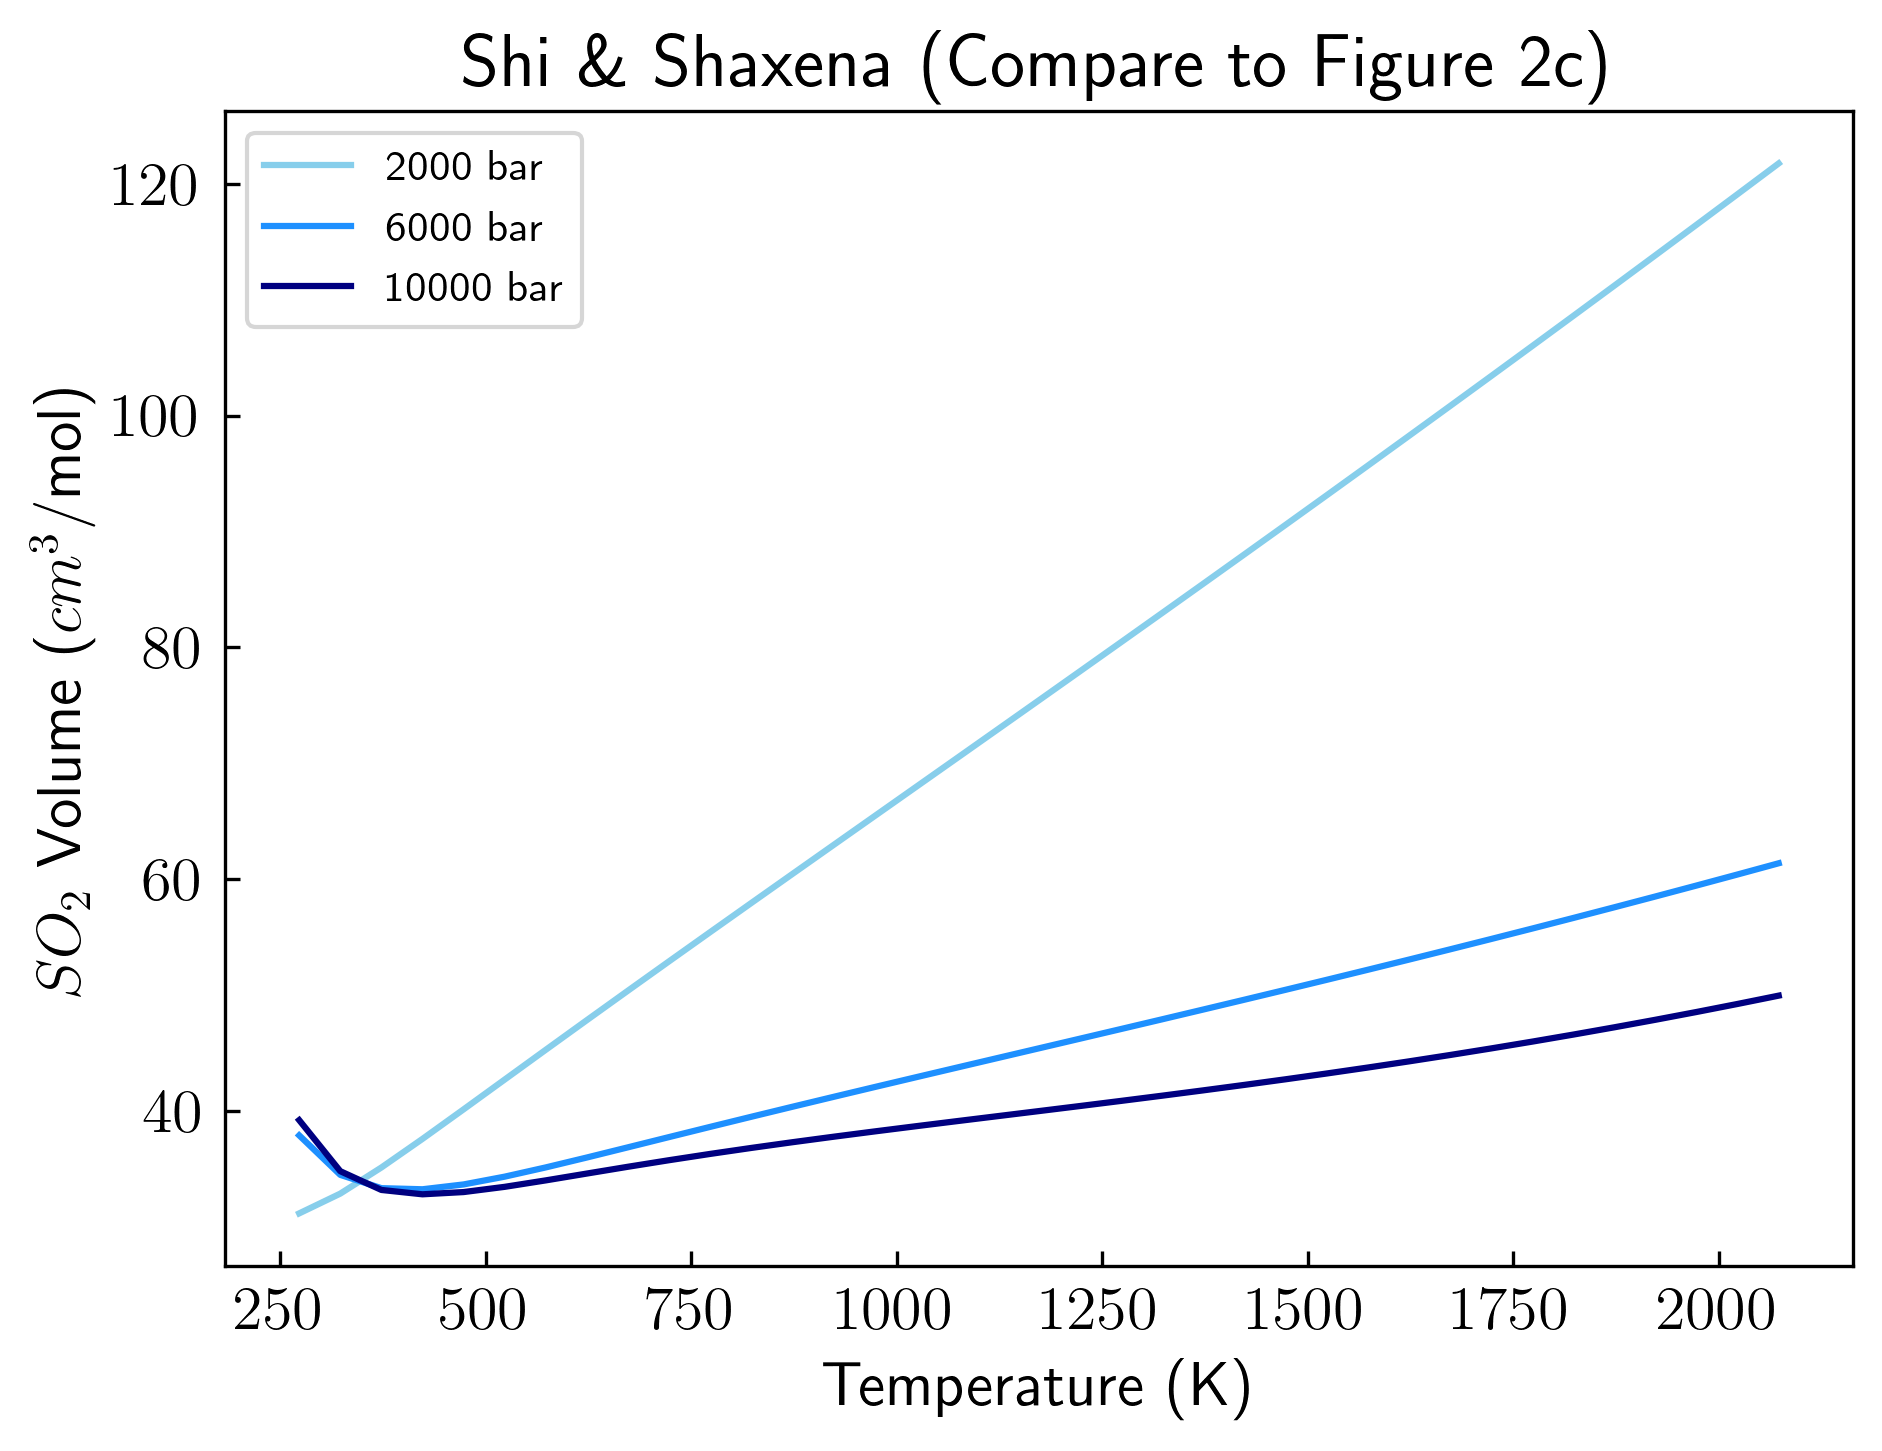

In [66]:
fig,axs = plt.subplots()
plt.plot(temp_arr_SF, SS_SO2_5bars, color='skyblue', label=r'5 bar')
plt.plot(temp_arr_SF, SS_SO2_10bars, color='dodgerblue', label=r'10 bar')
plt.plot(temp_arr_SF, SS_SO2_50bars, color='navy', label=r'50 bar')

plt.legend(fontsize='x-small')
plt.xlabel('Temperature (K)')
#plt.ylim(0, 600)
#plt.xlim(250, 2090)
plt.ylabel(r'$SO_2$ Volume ($cm^3$/mol)')
plt.title(r'Shi \& Shaxena (Compare to Figure 2a)')
plt.savefig('VolumevsT_ShiSaxena_SO2_2a.jpg', dpi=1000)
plt.show()

fig,axs = plt.subplots()
plt.plot(temp_arr_SF, SS_SO2_200bars, color='skyblue', label=r'200 bar')
plt.plot(temp_arr_SF, SS_SO2_600bars, color='dodgerblue', label=r'600 bar')
plt.plot(temp_arr_SF, SS_SO2_1000bars, color='navy', label=r'1000 bar')

plt.legend(fontsize='x-small')
plt.xlabel('Temperature (K)')
#plt.ylim(0, 600)
#plt.xlim(250, 2090)
plt.ylabel(r'$SO_2$ Volume ($cm^3$/mol)')
plt.title(r'Shi \& Shaxena (Compare to Figure 2b)')
plt.savefig('VolumevsT_ShiSaxena_SO2_2b.jpg', dpi=1000)
plt.show()

fig,axs = plt.subplots()
plt.plot(temp_arr_SF, SS_SO2_2000bars, color='skyblue', label=r'2000 bar')
plt.plot(temp_arr_SF, SS_SO2_6000bars, color='dodgerblue', label=r'6000 bar')
plt.plot(temp_arr_SF, SS_SO2_10000bars, color='navy', label=r'10000 bar')

plt.legend(fontsize='x-small')
plt.xlabel('Temperature (K)')
#plt.ylim(0, 600)
#plt.xlim(250, 2090)
plt.ylabel(r'$SO_2$ Volume ($cm^3$/mol)')
plt.title(r'Shi \& Shaxena (Compare to Figure 2c)')
plt.savefig('VolumevsT_ShiSaxena_SO2_2c.jpg', dpi=1000)
plt.show()

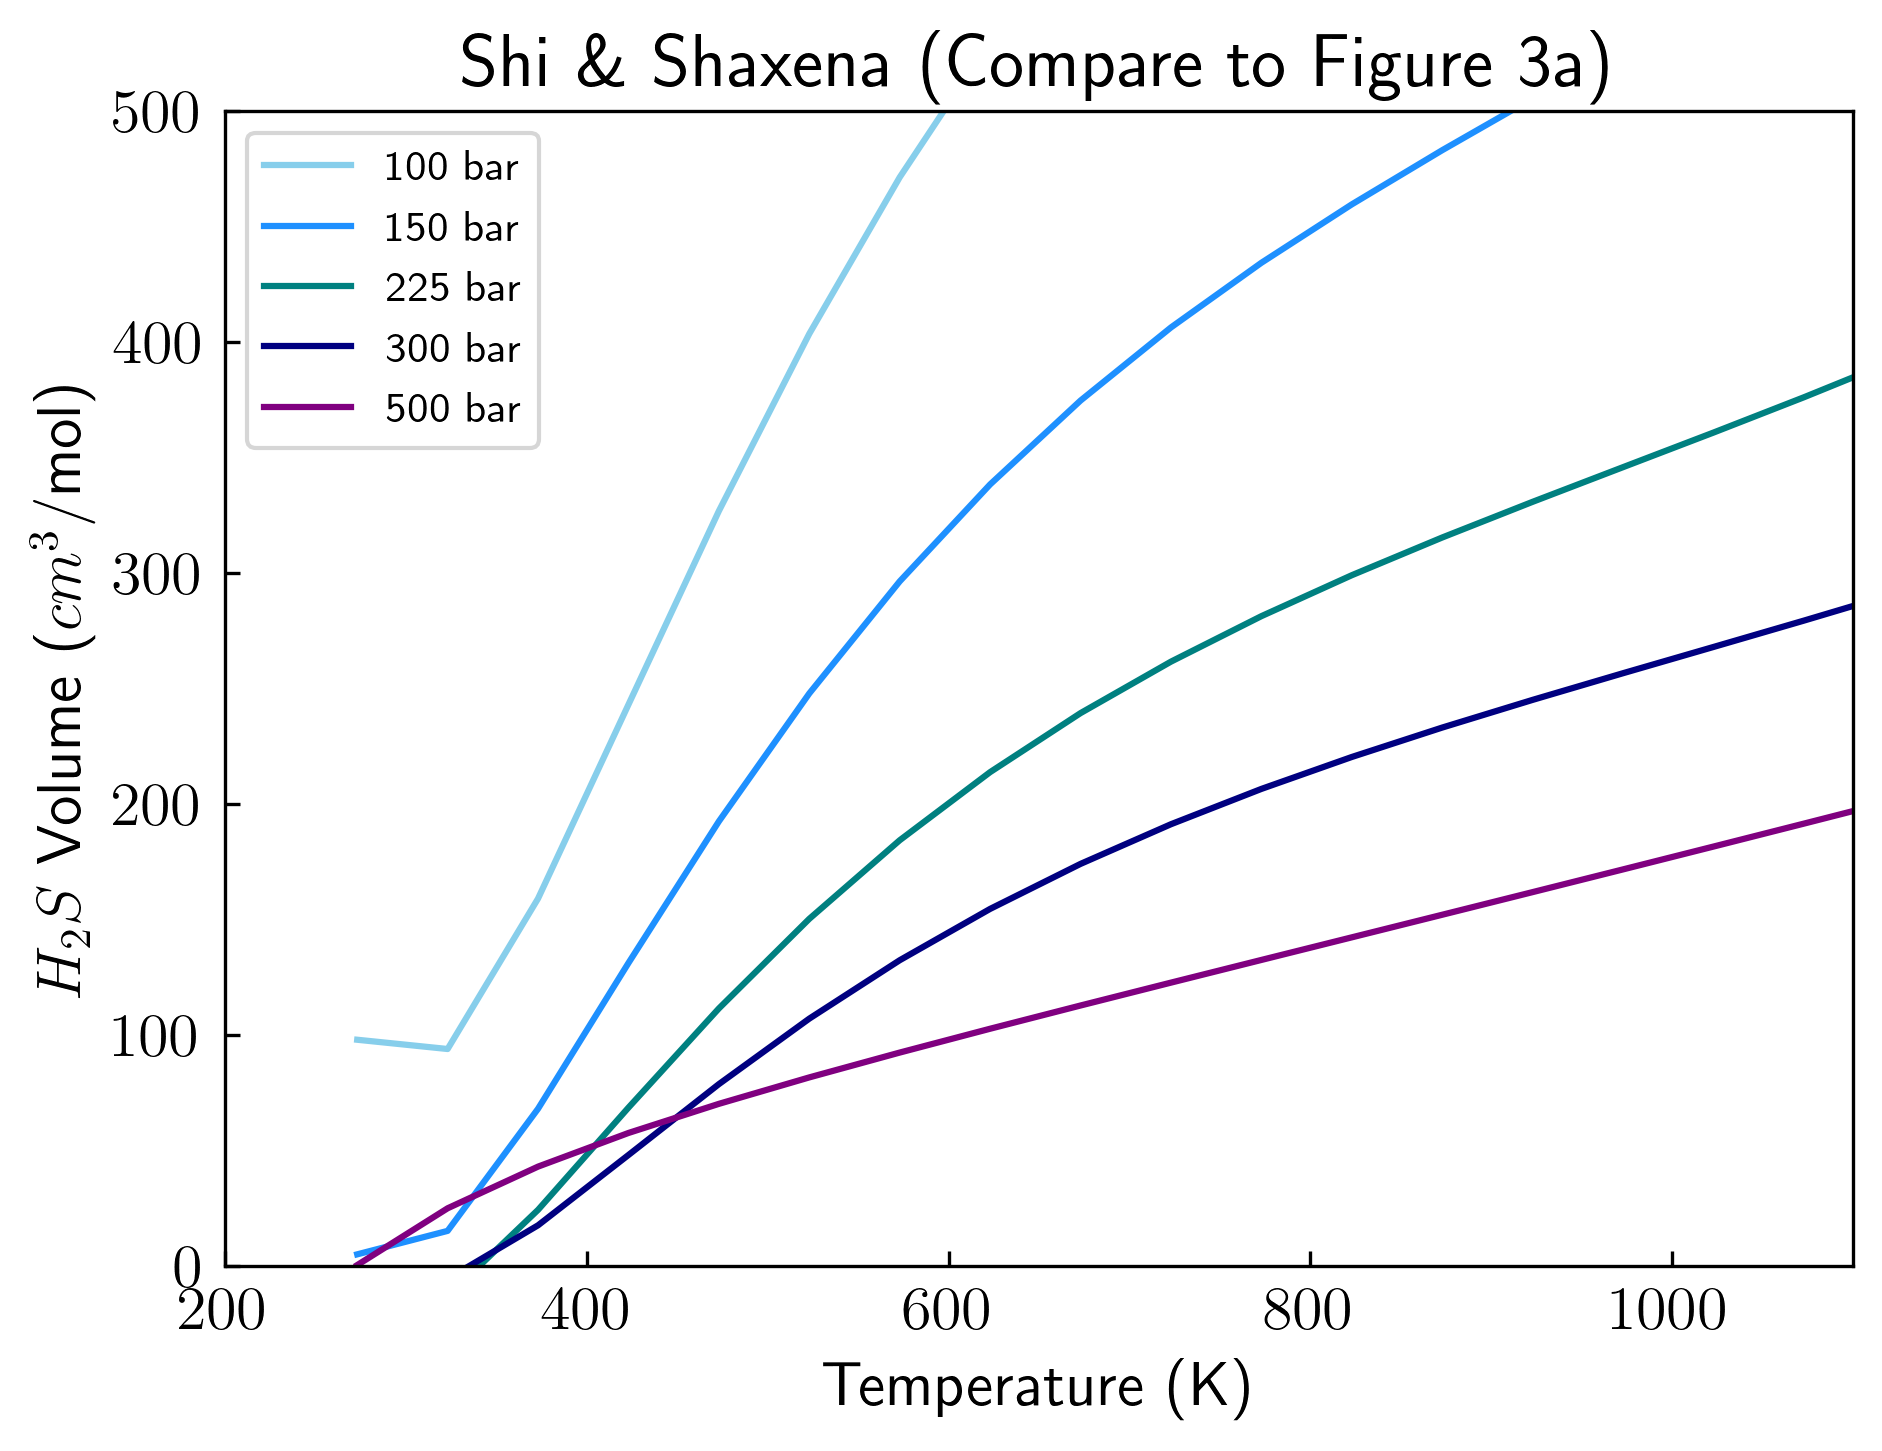

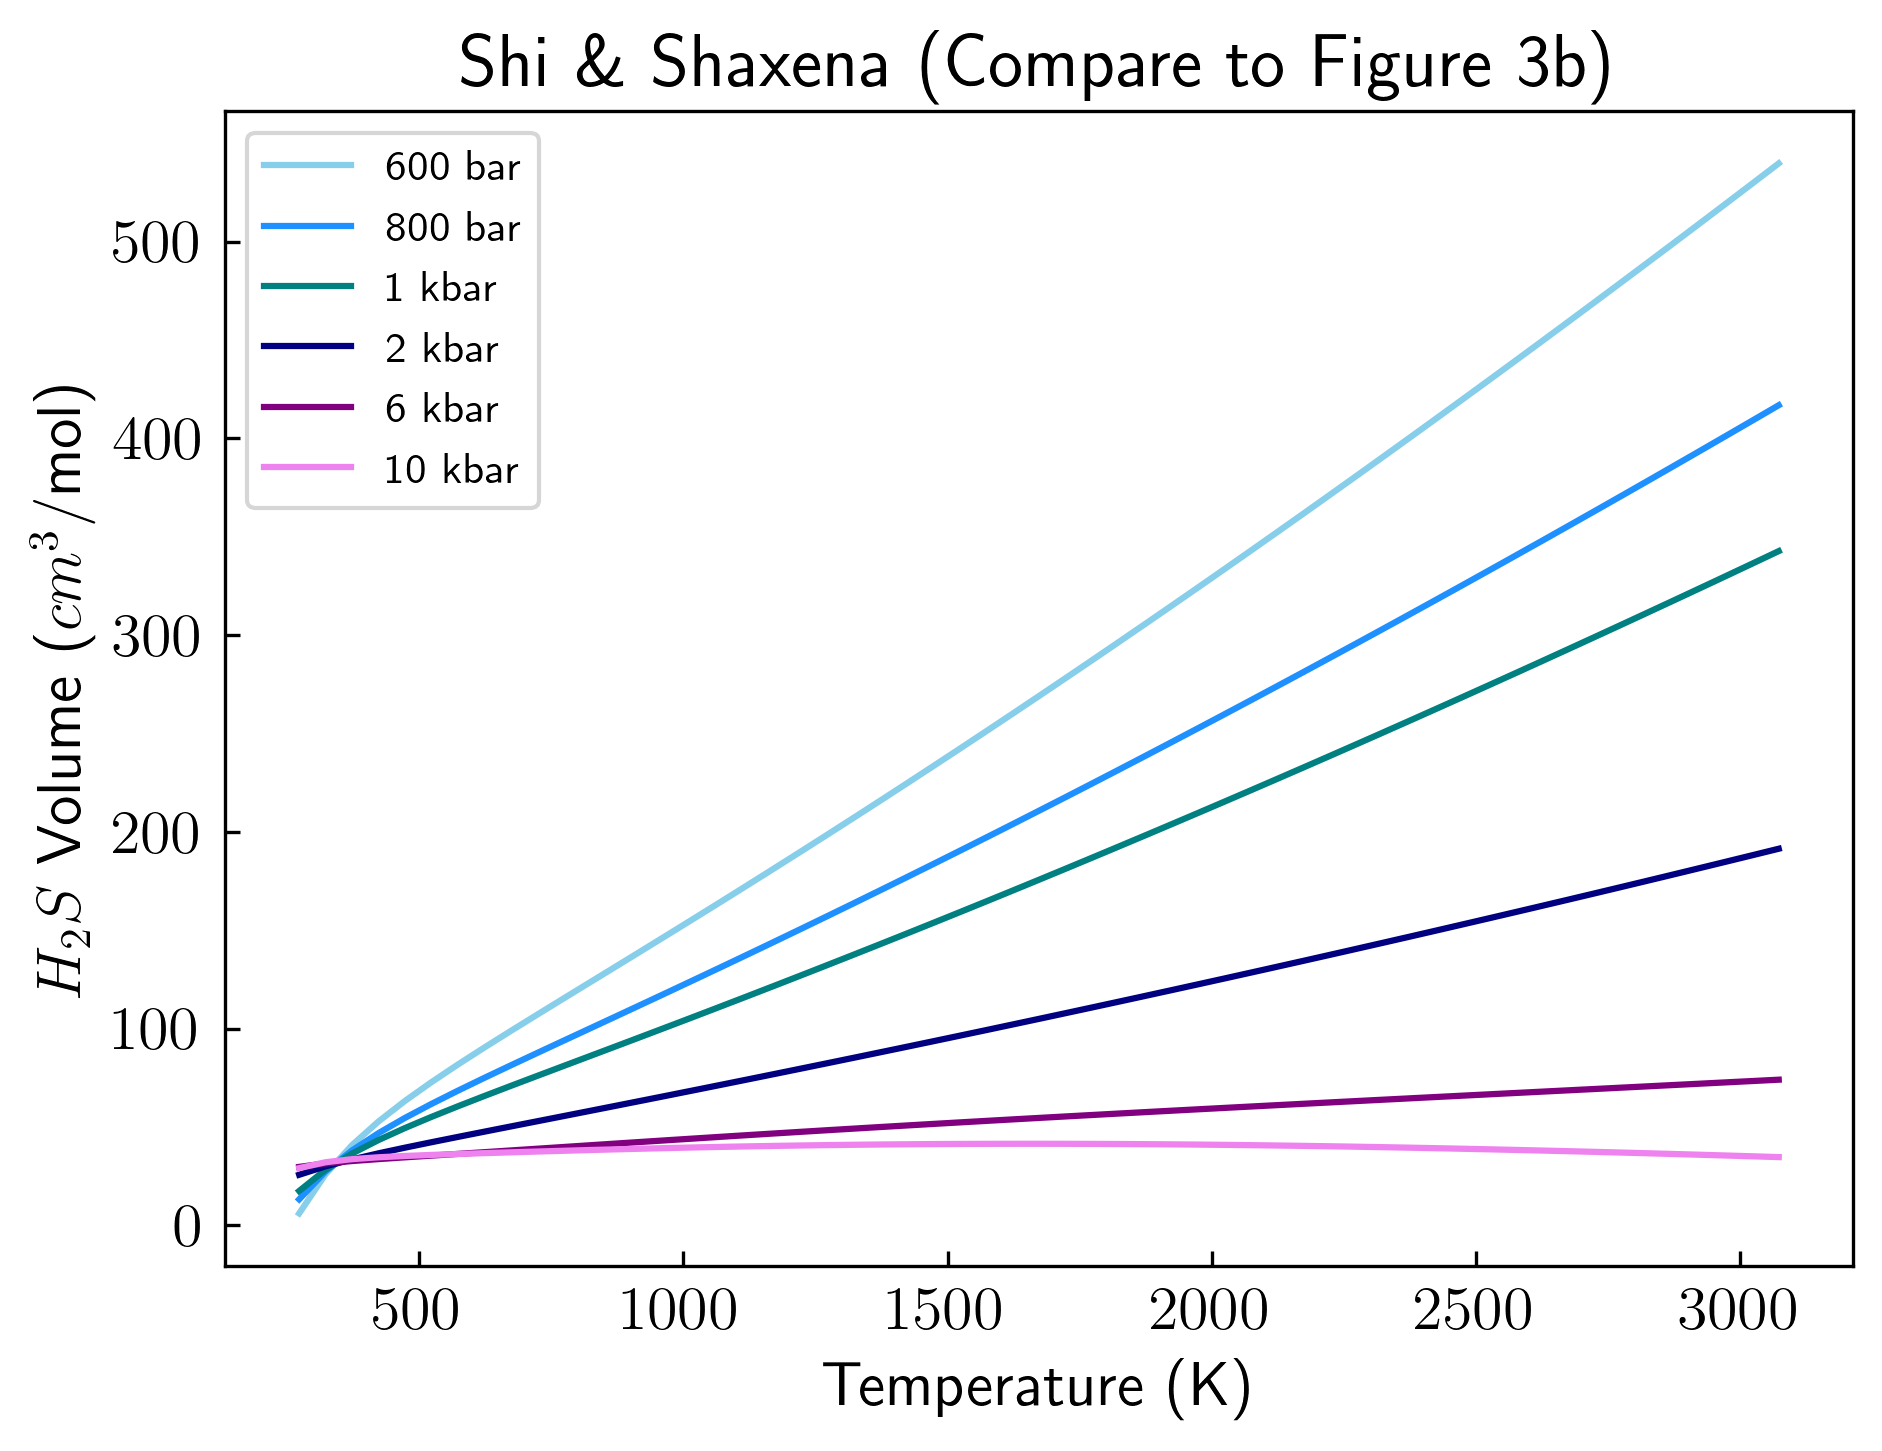

In [78]:
fig,axs = plt.subplots()
plt.plot(temp_arr_SF_hi, SS_H2S_100bars, color='skyblue', label=r'100 bar')
plt.plot(temp_arr_SF_hi, SS_H2S_150bars, color='dodgerblue', label=r'150 bar')
plt.plot(temp_arr_SF_hi, SS_H2S_225bars, color='teal', label=r'225 bar')
plt.plot(temp_arr_SF_hi, SS_H2S_300bars, color='navy', label=r'300 bar')
plt.plot(temp_arr_SF_hi, SS_H2S_500bars, color='purple', label=r'500 bar')

plt.legend(fontsize='x-small')
plt.xlabel('Temperature (K)')
plt.ylim(0, 500)
plt.xlim(200, 1100)
plt.ylabel(r'$H_2S$ Volume ($cm^3$/mol)')
plt.title(r'Shi \& Shaxena (Compare to Figure 3a)')
plt.savefig('VolumevsT_ShiSaxena_H2S_3a.jpg', dpi=1000)
plt.show()

fig,axs = plt.subplots()
plt.plot(temp_arr_SF_hi, SS_H2S_600bars, color='skyblue', label=r'600 bar')
plt.plot(temp_arr_SF_hi, SS_H2S_800bars, color='dodgerblue', label=r'800 bar')
plt.plot(temp_arr_SF_hi, SS_H2S_1000bars, color='teal', label=r'1 kbar')
plt.plot(temp_arr_SF_hi, SS_H2S_2000bars, color='navy', label=r'2 kbar')
plt.plot(temp_arr_SF_hi, SS_H2S_6000bars, color='purple', label=r'6 kbar')
plt.plot(temp_arr_SF_hi, SS_H2S_10000bars, color='violet', label=r'10 kbar')

plt.legend(fontsize='x-small')
plt.xlabel('Temperature (K)')
#plt.ylim(0, 600)
#plt.xlim(250, 2090)
plt.ylabel(r'$H_2S$ Volume ($cm^3$/mol)')
plt.title(r'Shi \& Shaxena (Compare to Figure 3b)')
plt.savefig('VolumevsT_ShiSaxena_H2S_3b.jpg', dpi=1000)
plt.show()

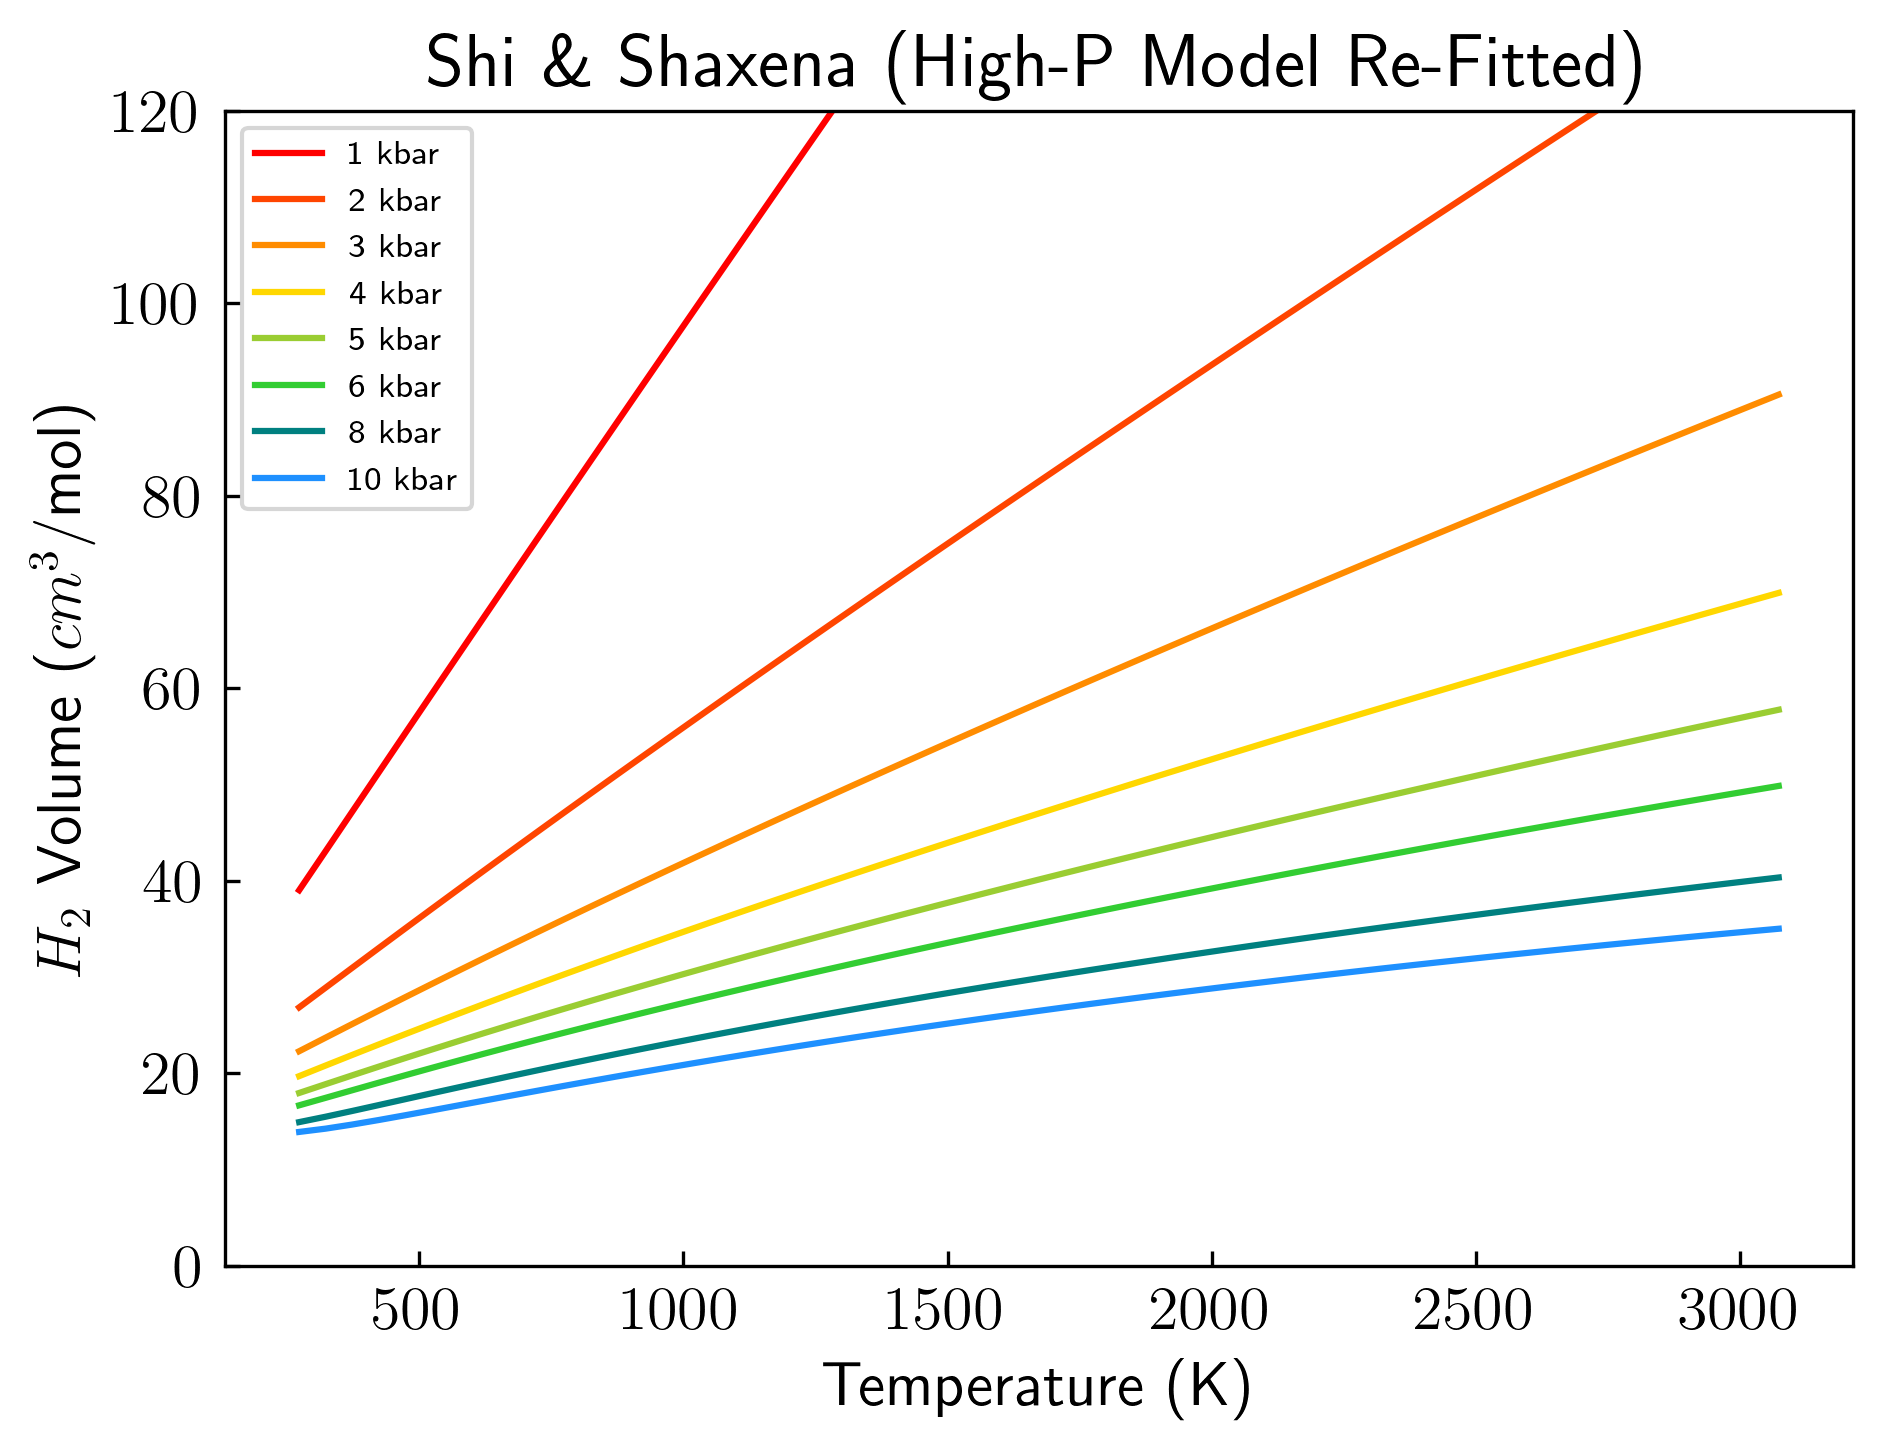

In [15]:
fig,ax = plt.subplots()
plt.plot(temp_arr_SF_hi, SS_model_1000bar_hi, color='red', label=r'1 kbar')
plt.plot(temp_arr_SF_hi, SS_model_2000bar, color='orangered', label=r'2 kbar')
plt.plot(temp_arr_SF_hi, SS_model_3000bar, color='darkorange', label=r'3 kbar')
plt.plot(temp_arr_SF_hi, SS_model_4000bar, color='gold', label=r'4 kbar')
plt.plot(temp_arr_SF_hi, SS_model_5000bar, color='yellowgreen', label=r'5 kbar')
plt.plot(temp_arr_SF_hi, SS_model_6000bar, color='limegreen', label=r'6 kbar')
plt.plot(temp_arr_SF_hi, SS_model_8000bar, color='teal', label=r'8 kbar')
plt.plot(temp_arr_SF_hi, SS_model_10000bar, color='dodgerblue', label=r'10 kbar')

plt.legend(fontsize=8)
plt.xlabel('Temperature (K)')
plt.ylim(0, 120)
#plt.xlim(250, 2090)
plt.ylabel(r'$H_2$ Volume ($cm^3$/mol)')
plt.title(r'Shi \& Shaxena (High-P Model Re-Fitted)')
plt.savefig('VolumevsT_ShiSaxena_1c_HighP.jpg', dpi=1000)
plt.show()

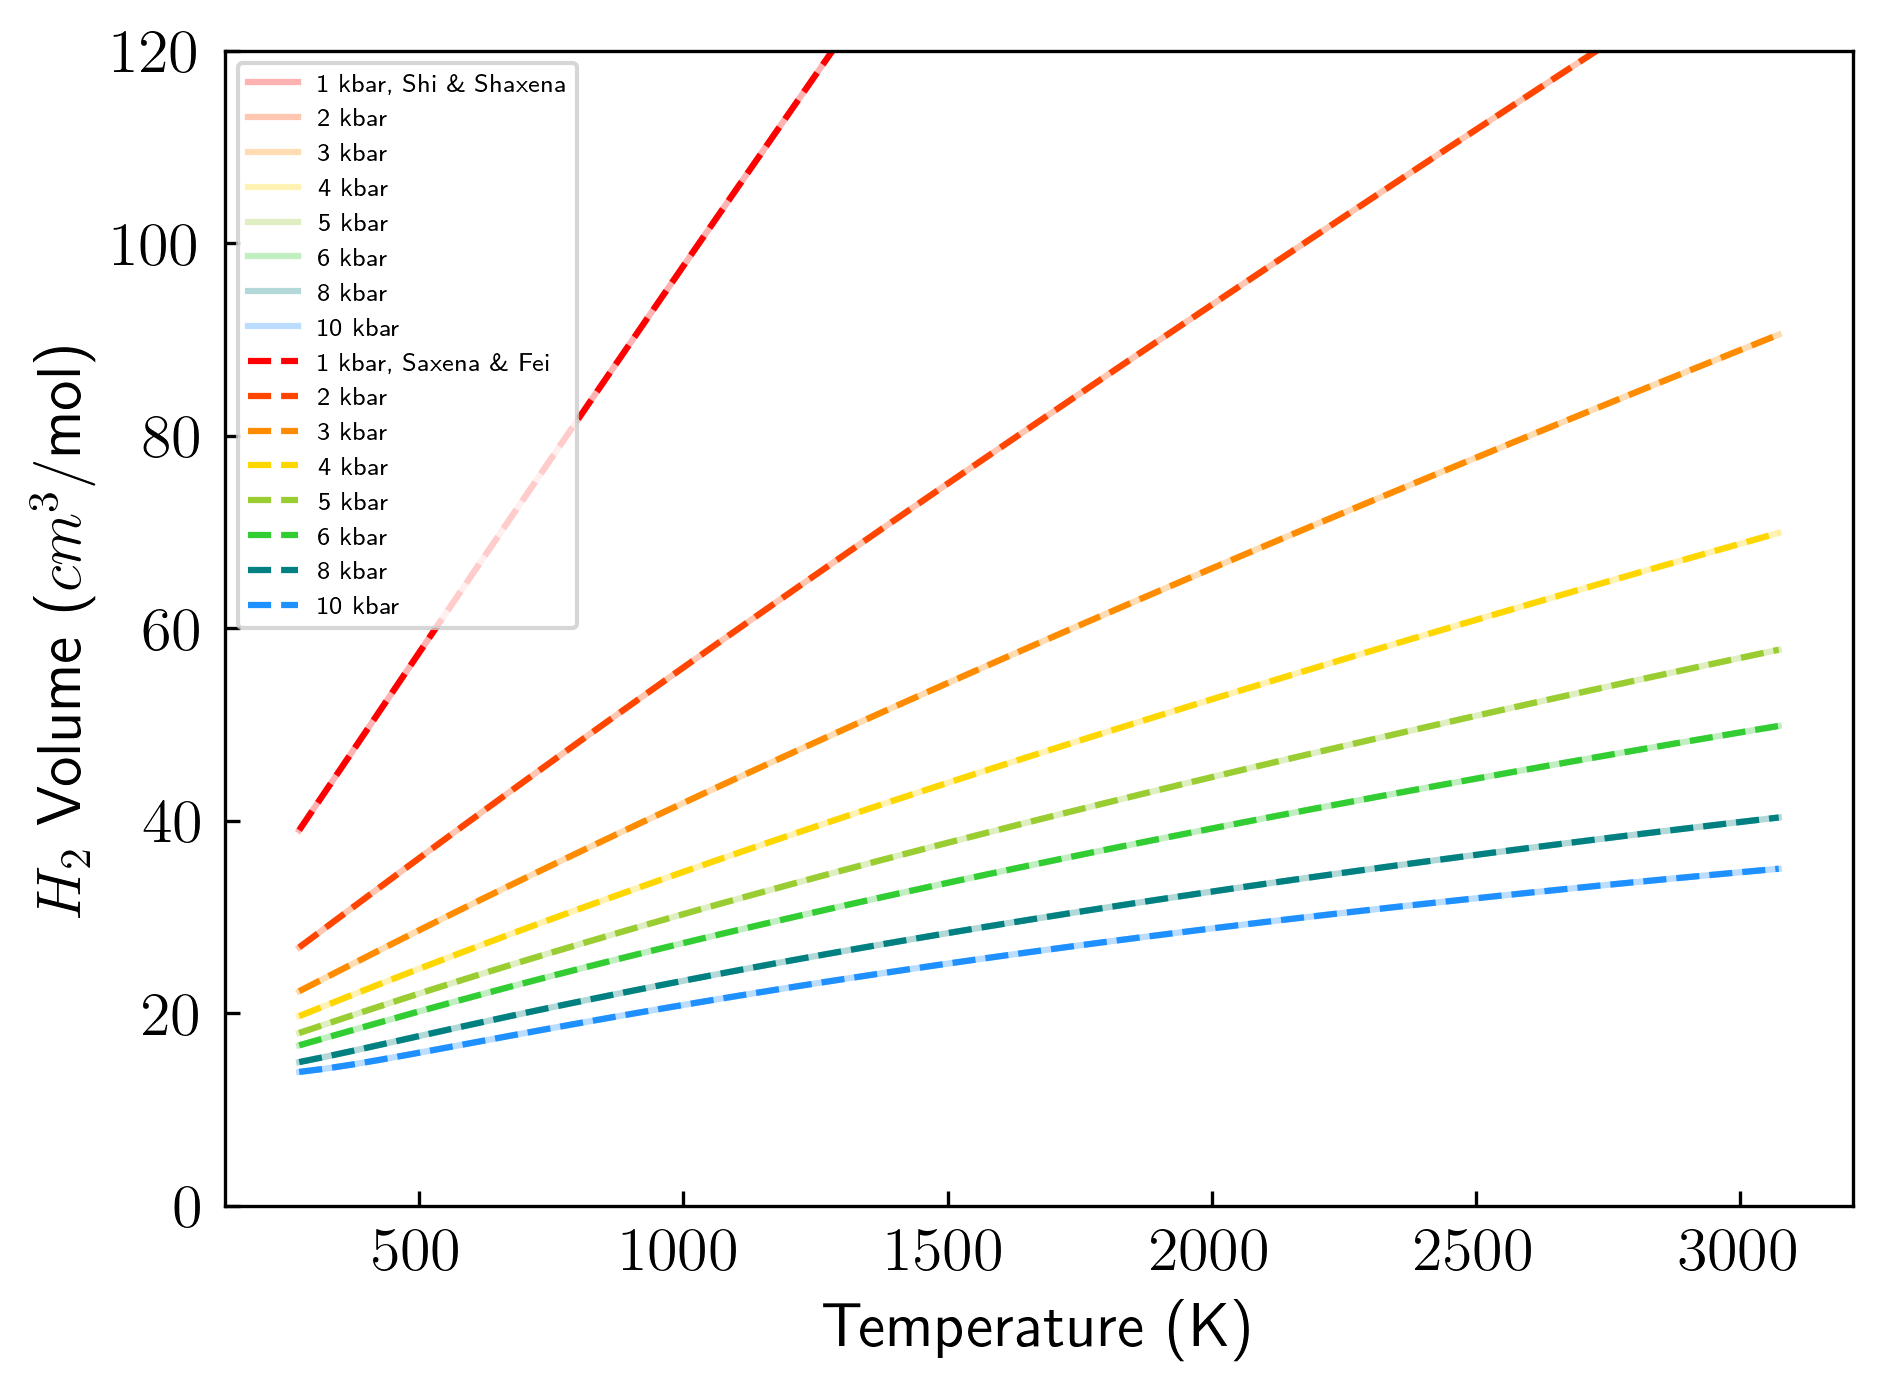

In [11]:
fig,ax = plt.subplots()
plt.plot(temp_arr_SF_hi, SS_model_1000bar_hi, color='red', alpha=0.3, label=r'1 kbar, Shi \& Shaxena')
plt.plot(temp_arr_SF_hi, SS_model_2000bar, color='orangered', alpha=0.3, label=r'2 kbar')
plt.plot(temp_arr_SF_hi, SS_model_3000bar, color='darkorange', alpha=0.3, label=r'3 kbar')
plt.plot(temp_arr_SF_hi, SS_model_4000bar, color='gold', alpha=0.3, label=r'4 kbar')
plt.plot(temp_arr_SF_hi, SS_model_5000bar, color='yellowgreen', alpha=0.3, label=r'5 kbar')
plt.plot(temp_arr_SF_hi, SS_model_6000bar, color='limegreen', alpha=0.3, label=r'6 kbar')
plt.plot(temp_arr_SF_hi, SS_model_8000bar, color='teal', alpha=0.3, label=r'8 kbar')
plt.plot(temp_arr_SF_hi, SS_model_10000bar, color='dodgerblue', alpha=0.3, label=r'10 kbar')

plt.plot(temp_arr_SF_hi, SF_model_1000bar, linestyle='--', color='red', label=r'1 kbar, Saxena \& Fei')
plt.plot(temp_arr_SF_hi, SF_model_2000bar, linestyle='--',color='orangered', label=r'2 kbar')
plt.plot(temp_arr_SF_hi, SF_model_3000bar, linestyle='--',color='darkorange', label=r'3 kbar')
plt.plot(temp_arr_SF_hi, SF_model_4000bar, linestyle='--',color='gold', label=r'4 kbar')
plt.plot(temp_arr_SF_hi, SF_model_5000bar, linestyle='--',color='yellowgreen', label=r'5 kbar')
plt.plot(temp_arr_SF_hi, SF_model_6000bar, linestyle='--',color='limegreen', label=r'6 kbar')
plt.plot(temp_arr_SF_hi, SF_model_8000bar, linestyle='--',color='teal', label=r'8 kbar')
plt.plot(temp_arr_SF_hi, SF_model_10000bar, linestyle='--',color='dodgerblue', label=r'10 kbar')

plt.legend(fontsize=6)
plt.xlabel('Temperature (K)')
plt.ylim(0, 120)
#plt.xlim(250, 2090)
plt.ylabel(r'$H_2$ Volume ($cm^3$/mol)')
#plt.title(r'Shi \& Shaxena (Low-P Model Extrapolated)')
plt.savefig('VolumevsT_HighP_ShiSaxenavsSaxenaFei.jpg', dpi=1000)
plt.show()

#### Saxena and H&P Comparison Plots

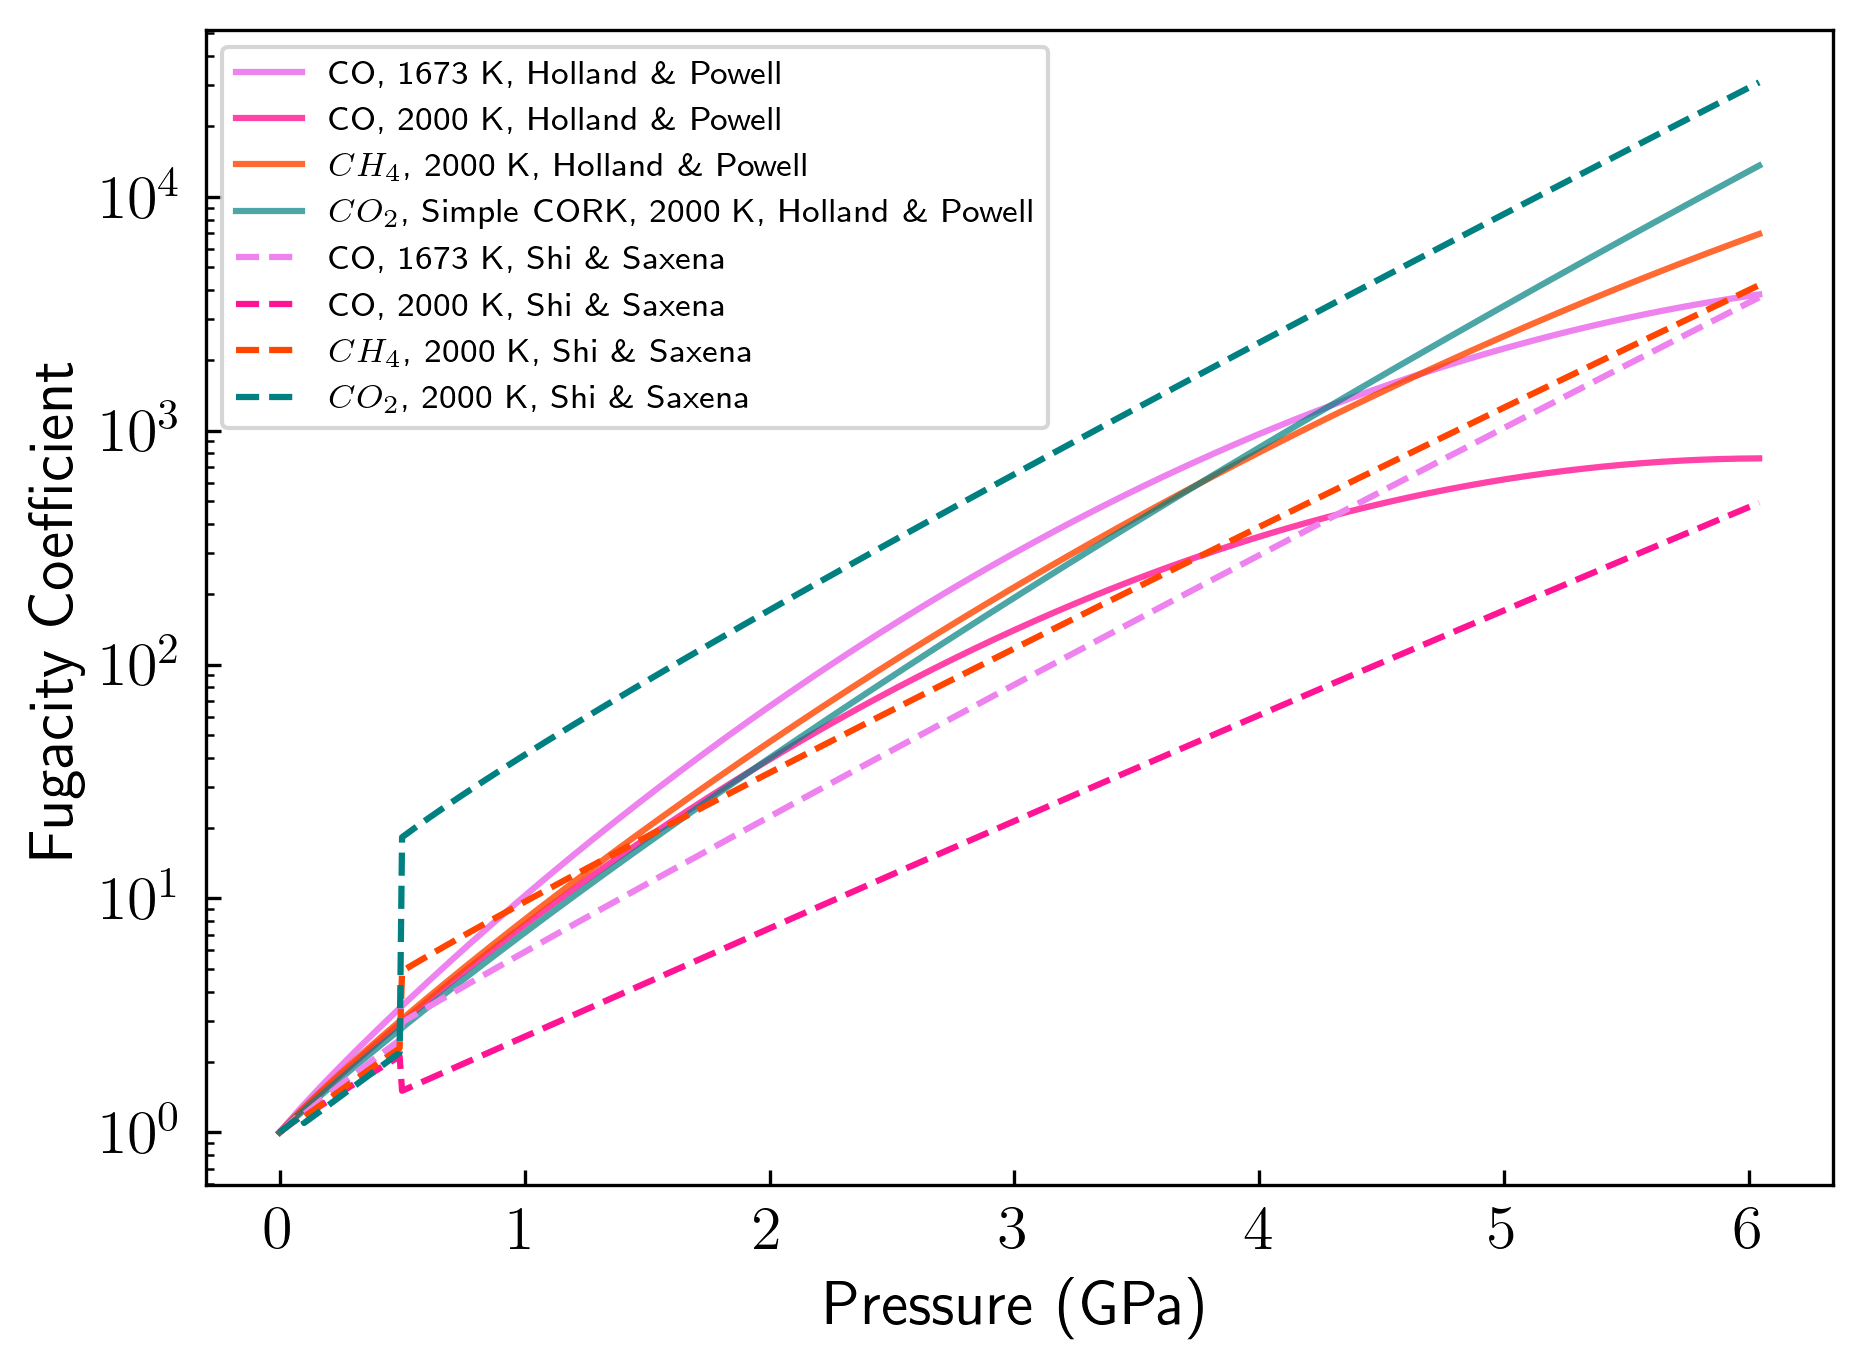

In [27]:
fig,ax = plt.subplots()
#plt.plot(pressure_arr/1e4, HP_2000, color='dodgerblue', alpha=0.8, label=r'$H_2$, 2000 K, Holland \& Powell')

plt.plot(pressure_arr/1e4, HP_1673_CO, color='violet',  label=r'CO, 1673 K, Holland \& Powell')
plt.plot(pressure_arr/1e4, HP_2000_CO, color='deeppink', alpha=0.8, label=r'CO, 2000 K, Holland \& Powell')
plt.plot(pressure_arr/1e4, HP_2000_CH4, color='orangered',  alpha=0.8, label=r'$CH_4$, 2000 K, Holland \& Powell')
plt.plot(pressure_arr/1e4, HP_2000_CO2Simple, color='teal', alpha=0.7, label=r'$CO_2$, Simple CORK, 2000 K, Holland \& Powell')

plt.plot(pressure_arr/1e4, SS_1673_CO, color='violet', linestyle='--', label=r'CO, 1673 K, Shi \& Saxena')
plt.plot(pressure_arr/1e4, SS_2000_CO, color='deeppink', linestyle='--', label=r'CO, 2000 K, Shi \& Saxena')
plt.plot(pressure_arr/1e4, SS_2000_CH4, color='orangered', linestyle='--', label=r'$CH_4$, 2000 K, Shi \& Saxena')
plt.plot(pressure_arr/1e4, SS_2000_CO2, color='teal', linestyle='--', label=r'$CO_2$, 2000 K, Shi \& Saxena')


plt.legend(fontsize=8)
plt.yscale('log')
#plt.ylim(0.1, 1e5)
#plt.xlim(-0.01, 8)
#plt.xscale('log')
plt.xlabel('Pressure (GPa)')
plt.ylabel(r'Fugacity Coefficient')
#plt.savefig('FugacityCoefficients_HP_VariousCorrespondingStates.jpg', dpi=1000)
plt.show()

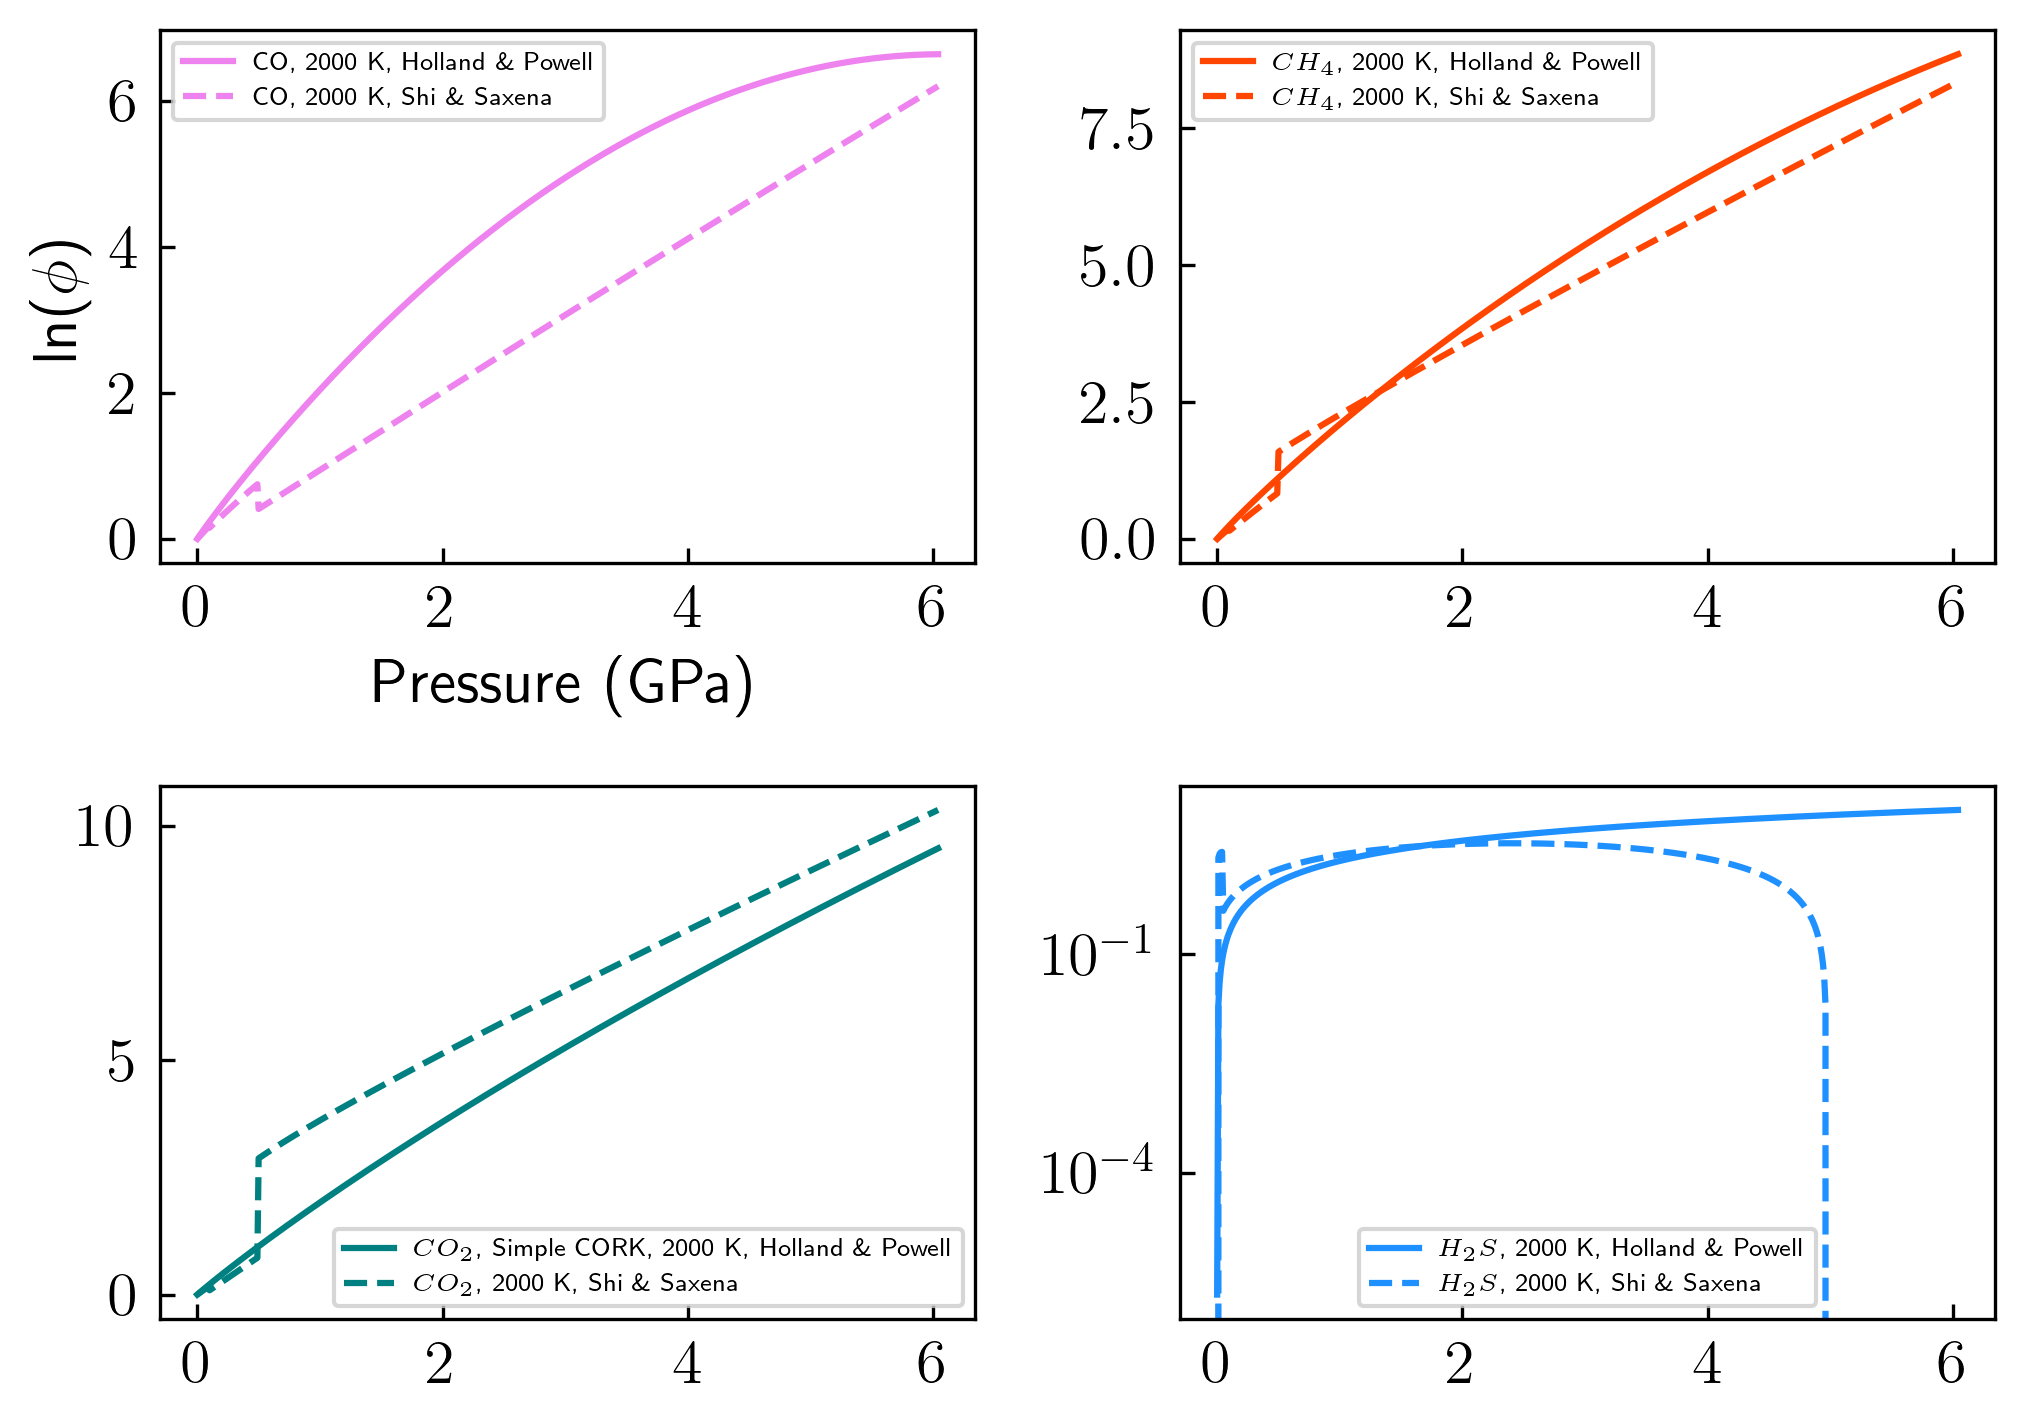

In [80]:
fig,axs = plt.subplots(2, 2)

axs[0, 0].plot(pressure_arr/1e4, np.log(HP_2000_CO), color='violet',  label=r'CO, 2000 K, Holland \& Powell')
axs[0, 0].plot(pressure_arr/1e4, np.log(SS_2000_CO), color='violet', linestyle='--', label=r'CO, 2000 K, Shi \& Saxena')

axs[0,1].plot(pressure_arr/1e4, np.log(HP_2000_CH4), color='orangered',  label=r'$CH_4$, 2000 K, Holland \& Powell')
axs[0,1].plot(pressure_arr/1e4, np.log(SS_2000_CH4), color='orangered', linestyle='--', label=r'$CH_4$, 2000 K, Shi \& Saxena')

axs[1,0].plot(pressure_arr/1e4, np.log(HP_2000_CO2Simple), color='teal',  label=r'$CO_2$, Simple CORK, 2000 K, Holland \& Powell')
axs[1,0].plot(pressure_arr/1e4, np.log(SS_2000_CO2), color='teal', linestyle='--', label=r'$CO_2$, 2000 K, Shi \& Saxena')

axs[1,1].plot(pressure_arr/1e4, np.log(HP_2000_H2S), color='dodgerblue',  label=r'$H_2S$, 2000 K, Holland \& Powell')
axs[1,1].plot(pressure_arr/1e4, np.log(SS_2000_H2S), color='dodgerblue', linestyle='--', label=r'$H_2S$, 2000 K, Shi \& Saxena')

axs[0,0].legend(fontsize=6)
axs[0,1].legend(fontsize=6)
axs[1,0].legend(fontsize=6)
axs[1,1].legend(fontsize=6)
plt.yscale('log')
#plt.ylim(0.1, 1e5)
#plt.xlim(-0.01, 8)
#plt.xscale('log')
axs[0,0].set(xlabel='Pressure (GPa)')
axs[0,0].set(ylabel=r'ln($\phi$)')
plt.tight_layout()
#plt.savefig('FugacityCoefficients_HPvsSaxena.jpg', dpi=1000)
plt.show()

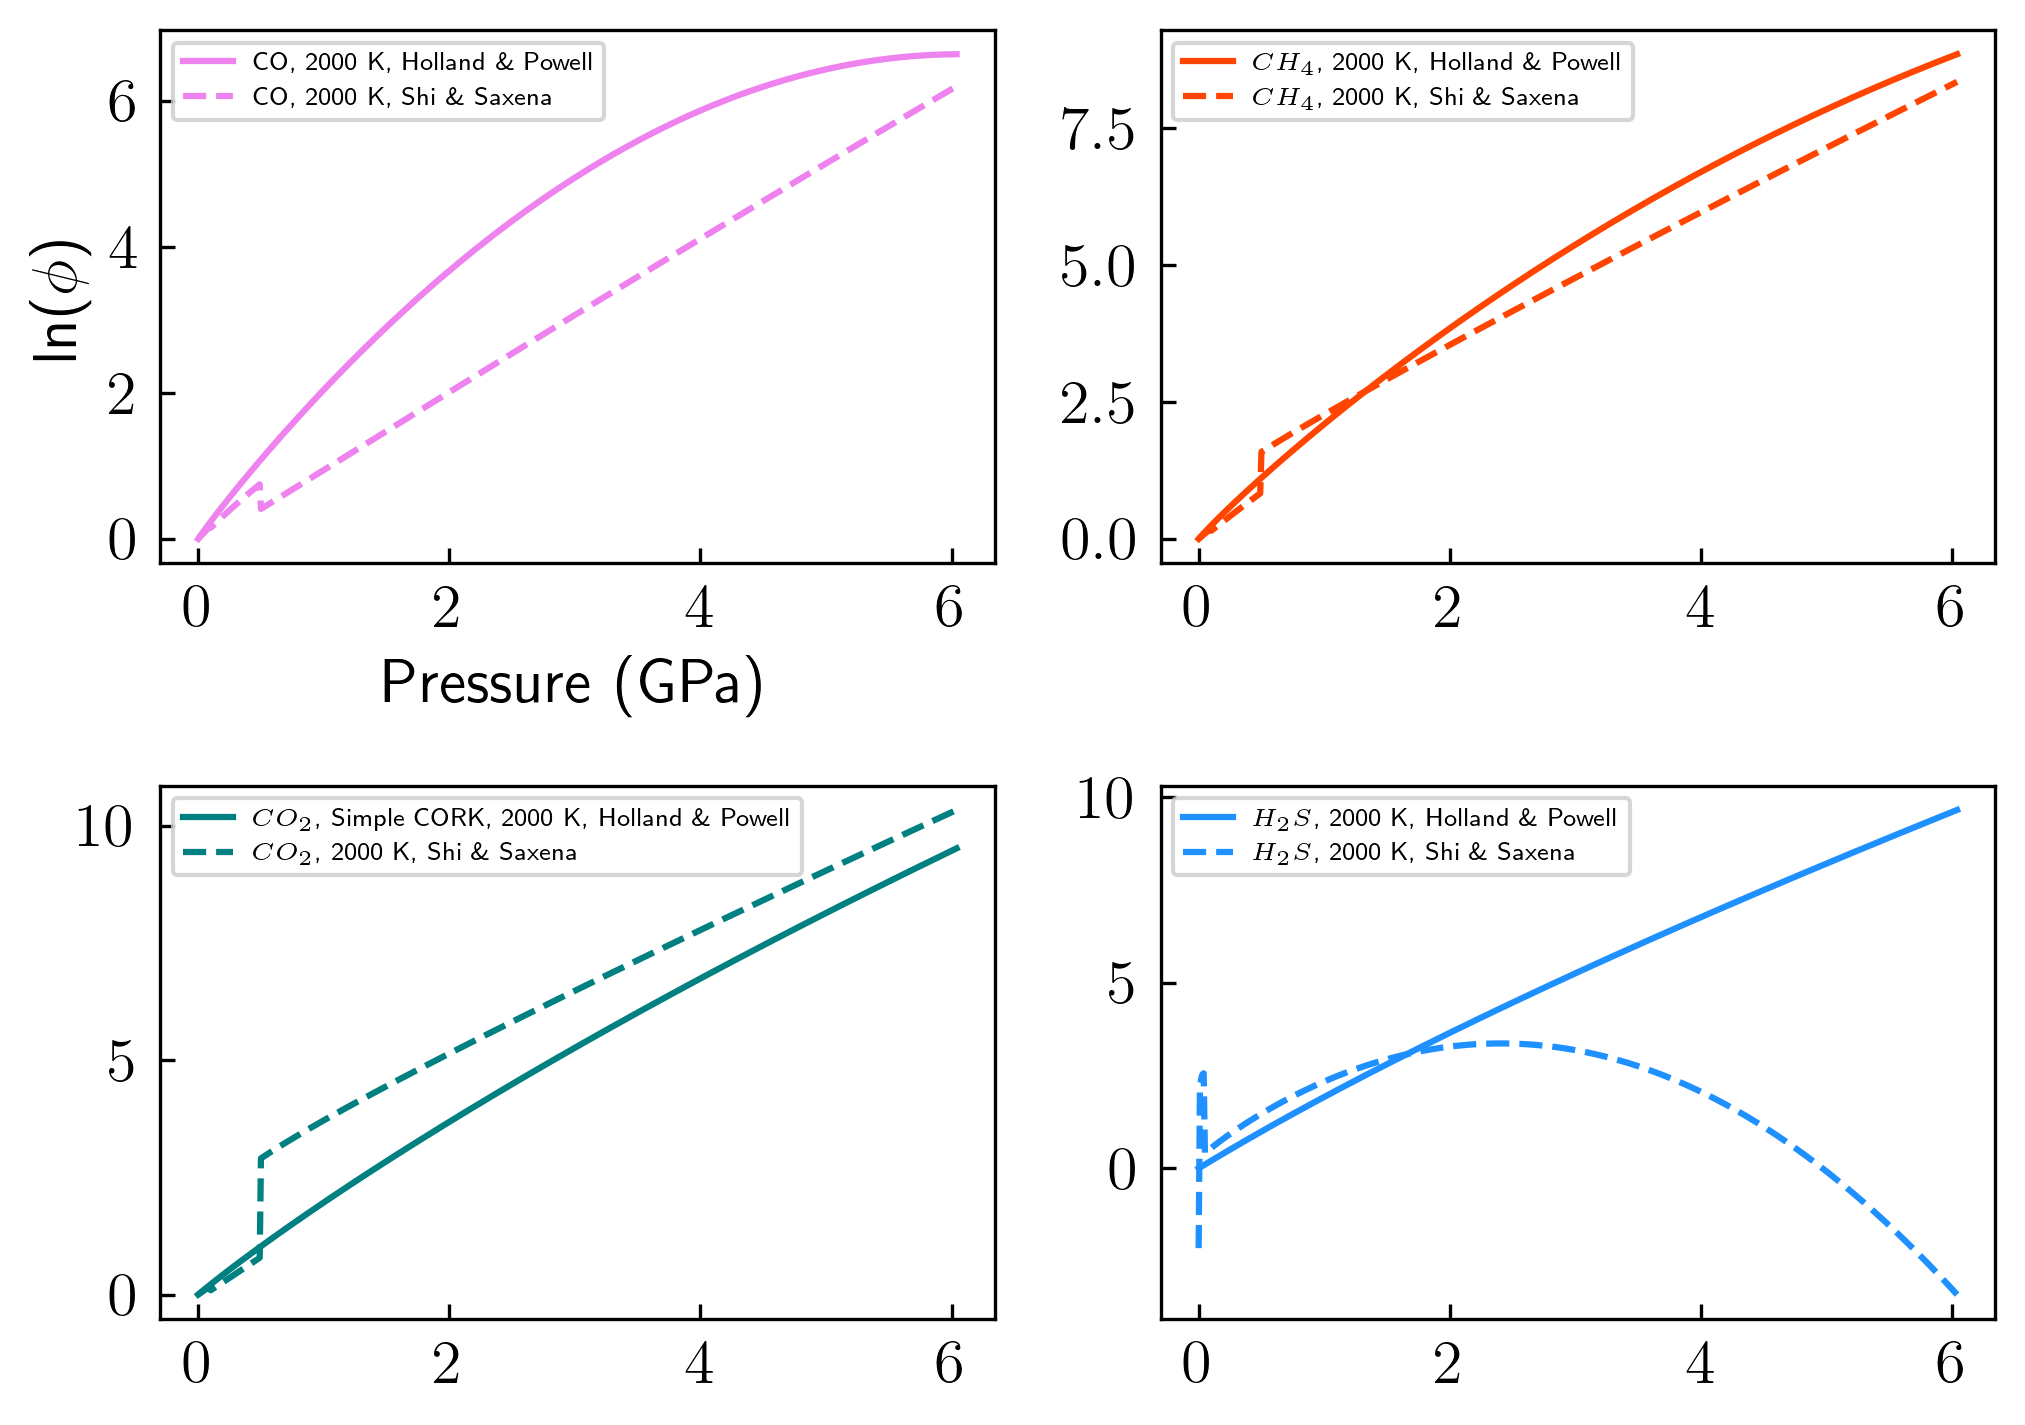

In [88]:
fig,axs = plt.subplots(2, 2)

axs[0, 0].plot(pressure_arr/1e4, np.log(HP_2000_CO), color='violet',  label=r'CO, 2000 K, Holland \& Powell')
axs[0, 0].plot(pressure_arr/1e4, np.log(SS_2000_CO), color='violet', linestyle='--', label=r'CO, 2000 K, Shi \& Saxena')

axs[0,1].plot(pressure_arr/1e4, np.log(HP_2000_CH4), color='orangered',  label=r'$CH_4$, 2000 K, Holland \& Powell')
axs[0,1].plot(pressure_arr/1e4, np.log(SS_2000_CH4), color='orangered', linestyle='--', label=r'$CH_4$, 2000 K, Shi \& Saxena')

axs[1,0].plot(pressure_arr/1e4, np.log(HP_2000_CO2Simple), color='teal',  label=r'$CO_2$, Simple CORK, 2000 K, Holland \& Powell')
axs[1,0].plot(pressure_arr/1e4, np.log(SS_2000_CO2), color='teal', linestyle='--', label=r'$CO_2$, 2000 K, Shi \& Saxena')

axs[1,1].plot(pressure_arr/1e4, np.log(HP_2000_H2S), color='dodgerblue',  label=r'$H_2S$, 2000 K, Holland \& Powell')
axs[1,1].plot(pressure_arr/1e4, np.log(SS_2000_H2S), color='dodgerblue', linestyle='--', label=r'$H_2S$, 2000 K, Shi \& Saxena')

axs[0,0].legend(fontsize=6)
axs[0,1].legend(fontsize=6)
axs[1,0].legend(fontsize=6)
axs[1,1].legend(fontsize=6)
#axs[0,0].set_xlim([0,2])
#axs[0,1].set_xlim([0,2])
#axs[1,0].set_xlim([0,2])
#axs[1,1].set_xlim([0,2])

#plt.yscale('log')
#plt.ylim(0.1, 1e5)
#plt.xlim(-0.01, 8)
#plt.xscale('log')
axs[0,0].set(xlabel='Pressure (GPa)')
axs[0,0].set(ylabel=r'ln($\phi$)')
plt.tight_layout()
plt.savefig('FugacityCoefficients_HPvsSaxena_lnphi.jpg', dpi=1000)
plt.show()